# Imports and pre-processing

#### Data Preparation and Merging:

In [1]:
import pandas as pd
import numpy as np
import json
from itertools import zip_longest

# Read in the tables from CSV files
votes = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-votes_0.csv')
proposals = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-proposals_0.csv')
spaces = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-spaces_0.csv')
follows = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-follows_0.csv')
users = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-users_0.csv')

# Sequentially merge dataframes
df = votes.merge(proposals, how='left', left_on='proposal', right_on='id', suffixes=('_vote', '_proposal'))
df = df.merge(spaces, how='left', left_on='space_vote', right_on='id', suffixes=('', '_space'))
df = df.merge(follows, how='left', left_on=['voter', 'space_vote'], right_on=['follower', 'space'], suffixes=('', '_follow'))
df = df.merge(users, how='left', left_on='voter', right_on='id', suffixes=('', '_user'))

/var/folders/f4/sh07l6153kdf65d301tvvp8h0000gn/T/ipykernel_4405/2535206019.py:7: DtypeWarning: Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-votes_0.csv')
/var/folders/f4/sh07l6153kdf65d301tvvp8h0000gn/T/ipykernel_4405/2535206019.py:8: DtypeWarning: Columns (6,9,13,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  proposals = pd.read_csv('data_room/csvs/snapshot-hub-mainnet-2023-08-30-proposals_0.csv')


In [2]:
# Filter out the required rows based on the 'type' column
data_filtered = df[df['type'].isin(['basic', 'single-choice', 'weighted', 'quadratic', 'approval', 'ranked-choice'])]

# Filter for DAO Verified Spaces only
# 1. Read in the CSV file containing the verified DAO spaces
dao_spaces_df = pd.read_csv('data_room/csvs/verified-spaces.csv')  
# 2. Extract the unique 'space_name' values into a list
verified_dao_spaces = dao_spaces_df['space_name'].unique().tolist()
# 3. Use the list to filter rows in 'data_filtered'
data_basic = data_filtered[data_filtered['space_vote'].isin(verified_dao_spaces)]

In [3]:
# Keep these columns and drop the rest for performance improvement
required_columns = [
    'choice', 'voter', 'space_vote', 'created_vote', 'start', 'end', 'proposal', 'created_at', 'title',
    'strategies', 'vp', 'vp_by_strategy', 'network', 'type', 'choices', 'quorum', 'scores', 'scores_by_strategy', 'scores_total', 'votes', 'settings'
]

# Only keep required columns
data_basic = data_basic[required_columns]

In [4]:
pd.set_option('display.max_columns', None)

#print data_basic header and first rows
data_basic.head(5)

,choice,voter,space_vote,created_vote,start,end,proposal,created_at,title,strategies,vp,vp_by_strategy,network,type,choices,quorum,scores,scores_by_strategy,scores_total,votes,settings
0,1,0x28143659f4500411D9E49513B88E66CDF81F9002,balancer.eth,1595088724,1.595088e+09,1.595174e+09,QmXYVj4GBu16GfuTLouxQSvbB8w3G2EAvYq9TAxX38ruKb,1.629285e+09,Modifying feeFactor: toward reducing the minin...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",39.797801,"[39.79780129967719,0,0]",1.0,single-choice,"[""Approve"",""Reject""]",0.0,"[250809.7114714248,9.235183242137136]","[[247042.11576416524,3767.59570725957,0],[9.23...",250818.946655,72.0,"{""name"":""Balancer"",""skin"":""balancer"",""admins"":..."
1,1,0x4aa2c2C321d86e6ce9C5b1faD7c2e084D867Dea3,balancer.eth,1595088738,1.595088e+09,1.595174e+09,QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ,1.629285e+09,balFactor: incentivizing BAL liquidity on Bala...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",10.000000,"[10,0,0]",1.0,single-choice,"[""Approve"",""Reject""]",0.0,"[301714.28164624,176.5156161669749]","[[297407.78291458864,4306.498731651296,0],[163...",301890.797262,97.0,"{""name"":""Balancer"",""skin"":""balancer"",""admins"":..."
2,1,0x911F80D16Ec1B70Db332227b03beb871aC58Ead7,balancer.eth,1595088742,1.595088e+09,1.595174e+09,QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ,1.629285e+09,balFactor: incentivizing BAL liquidity on Bala...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",4925.346413,"[4925.346413169224,0,0]",1.0,single-choice,"[""Approve"",""Reject""]",0.0,"[301714.28164624,176.5156161669749]","[[297407.78291458864,4306.498731651296,0],[163...",301890.797262,97.0,"{""name"":""Balancer"",""skin"":""balancer"",""admins"":..."
3,1,0xD98e44D09660A89022515d6d41662d05A14253e7,balancer.eth,1595088759,1.595088e+09,1.595174e+09,QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ,1.629285e+09,balFactor: incentivizing BAL liquidity on Bala...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",528.412886,"[528.4128861422921,0,0]",1.0,single-choice,"[""Approve"",""Reject""]",0.0,"[301714.28164624,176.5156161669749]","[[297407.78291458864,4306.498731651296,0],[163...",301890.797262,97.0,"{""name"":""Balancer"",""skin"":""balancer"",""admins"":..."
4,1,0xD98e44D09660A89022515d6d41662d05A14253e7,balancer.eth,1595088811,1.595088e+09,1.595174e+09,QmXYVj4GBu16GfuTLouxQSvbB8w3G2EAvYq9TAxX38ruKb,1.629285e+09,Modifying feeFactor: toward reducing the minin...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",528.412886,"[528.4128861422921,0,0]",1.0,single-choice,"[""Approve"",""Reject""]",0.0,"[250809.7114714248,9.235183242137136]","[[247042.11576416524,3767.59570725957,0],[9.23...",250818.946655,72.0,"{""name"":""Balancer"",""skin"":""balancer"",""admins"":..."


In [ ]:
# Select a sample of the whole dataset data_basic
def sample_from_data(data, n_rows, seed):
    """Sample a specified number of rows from the input data."""
    return data.sample(n=n_rows, random_state=seed)

# Usage: You must specify both n_rows and seed values
data_basic_sample = sample_from_data(data_basic, n_rows=1000000, seed=42)

max_rows_data_basic = len(data_basic)
print(f"Maximum number of rows in data_basic: {max_rows_data_basic}")

Maximum number of rows in data_basic: 23768162


In [ ]:
# Save the DataFrame to a pickle file
data_basic.to_pickle('data_room/pickle_files/data_basic.pkl')

In [6]:
import pandas as pd
import numpy as np
import json
from itertools import zip_longest
# Load 'data_basic' DataFrame from the pickle file
data_basic = pd.read_pickle('data_room/pickle_files/data_basic.pkl')

# Feature Engineering:

#### Functions

In [7]:
# 1. Filtering and Sorting
data_basic_copy = data_basic.copy()

# Sort the copied DataFrame based on the specified columns
data_basic_copy.sort_values(by=['voter', 'space_vote', 'created_vote'], inplace=True)

In [8]:
2. # Determine the winning choice for each proposal based on scores
def determine_winning_choice(row):
    # Extracting scores
    scores = row['scores']
    
    # Check if scores is not null and not empty
    if not (pd.isnull(scores)) and scores:
        # Decoding the stringified lists
        scores_list = eval(scores)
        
        # Convert all elements to integers
        scores_list = [int(x) if isinstance(x, str) and x.isdigit() else x for x in scores_list]

        # Check if scores_list is not empty
        if scores_list:
            # Return the index of the maximum score, but add 1 to make it start from 1
            return scores_list.index(max(scores_list)) + 1
    return None

# Apply the function to the filtered dataset data_basic
data_basic_copy['winning_choice'] = data_basic_copy.apply(determine_winning_choice, axis=1)

In [9]:
# 3. Function to determine each voter's past voting participation
def calculate_past_vote_participation(data):
    last_vote_by_user_in_space = {}
    Participated_Before = []

    for index, row in data.iterrows():
        user = row['voter']
        space = row['space_vote']

        # Check if user has voted before in the space
        if (user, space) in last_vote_by_user_in_space:
            Participated_Before.append(1)
        else:
            Participated_Before.append(0)

        last_vote_by_user_in_space[(user, space)] = row['choice']

    return Participated_Before

# Usage and applying the function to the dataframe:
past_participation = calculate_past_vote_participation(data_basic_copy)
data_basic_copy['Participated_Before'] = calculate_past_vote_participation(data_basic_copy)

# 3.1 Function to determine if a voter has participated in the previous proposal within the same DAO
def participated_in_previous_proposal(data):
    # First, sort data by space_vote, start (timestamp of the proposal), and proposal
    data = data.sort_values(by=['space_vote', 'start', 'proposal'])
    
    # Group by voter and space_vote, then shift the proposal column within each group
    data['prev_proposal'] = data.groupby(['voter', 'space_vote'])['proposal'].shift(1)

    # Create a list to store the results for each row
    participated = []

    for index, row in data.iterrows():
        # Check if the previous proposal is not NaN and is different from the current proposal
        if pd.notna(row['prev_proposal']) and row['prev_proposal'] != row['proposal']:
            participated.append(1)
        else:
            participated.append(0)

    return participated

# Applying the function to the dataframe
data_basic_copy['Participated_in_previous_proposal'] = participated_in_previous_proposal(data_basic_copy)

# 3.2 Function to calculate the total number of proposals participated by each voter in each space
def compute_total_proposals_participated(data):
    # Sort the data first
    data = data.sort_values(by=['space_vote', 'start', 'proposal'])

    # Calculate the cumulative count of participated proposals for each voter in each space
    data['Total_Proposals_Participated'] = data.groupby(['voter', 'space_vote']).cumcount()

    # Since we want to exclude the current proposal from the count (as we're checking until the current proposal), we can subtract 1 from the count
    data['Total_Proposals_Participated'] = data['Total_Proposals_Participated'].apply(lambda x: max(0, x))

    return data

# Applying the function to the dataframe
data_basic_copy = compute_total_proposals_participated(data_basic_copy)

In [10]:
# 4. Function to determine each voter's past alignment with winning choice
def calculate_vote_alignment(data):
    # Mapping each space and proposal to its winning choice
    winning_choice_by_space_proposal = data.set_index(['space_vote', 'proposal'])['winning_choice'].to_dict()
    Aligned = []
    Misaligned = []
    NotDetermined = []
    
    for index, row in data.iterrows():
        space = row['space_vote']
        proposal = row['proposal']
        voting_type = row.get('type', '')  # Retrieve the voting type if it exists
        
        # Initialize an empty dictionary for voter choices
        choice_dict = {}
        
        # Handle different types of choice
        if isinstance(row['choice'], str):
            if row['choice'].startswith('{') and voting_type in ['weighted', 'quadratic']:
                # JSON dictionary-like string
                choice_dict = json.loads(row['choice'])
            elif row['choice'].startswith('[') and voting_type == 'ranked-choice':
                # JSON list-like string for ranked-choice voting
                voter_choices = json.loads(row['choice'])
                choice_dict = {str(int(choice)): 1 for choice in voter_choices[:3]}  # Convert to dict, take up to the first three choices
            else:
                try:
                    # Single choice as a string
                    choice_dict[str(int(row['choice']))] = 1
                except ValueError:
                    pass
        elif isinstance(row['choice'], (int, float)):
            # Single numeric choice
            choice_dict[str(int(row['choice']))] = 1
        elif isinstance(row['choice'], list) and voting_type == 'ranked-choice':
            # List of choices for ranked-choice voting
            choice_dict = {str(int(choice)): 1 for choice in row['choice'][:3]}  # Convert to dict, take up to the first three choices

        winning_choice = winning_choice_by_space_proposal.get((space, proposal), None)
        
        if winning_choice is None or pd.isna(winning_choice) or not choice_dict:
            Aligned.append(0)
            Misaligned.append(0)
            NotDetermined.append(1)
        else:
            # Ensure winning_choice is a string to match keys in choice_dict
            winning_choice = str(int(winning_choice))
            total_weight = sum(choice_dict.values())
            winning_weight = choice_dict.get(winning_choice, 0)
            
            if total_weight > 0:
                winning_proportion = winning_weight / total_weight
            else:
                winning_proportion = 0
            
            misalignment_score = 1 - winning_proportion
            
            if winning_proportion > 0:
                Aligned.append(1)
                Misaligned.append(misalignment_score)
                NotDetermined.append(0)
            else:
                Aligned.append(0)
                Misaligned.append(1)  # Fully misaligned as the winning choice was not selected
                NotDetermined.append(0)
                
    return Aligned, Misaligned, NotDetermined

# Applying the function to the dataframe
data_basic_copy['Aligned'], data_basic_copy['Misaligned'], data_basic_copy['NotDetermined'] = calculate_vote_alignment(data_basic_copy)

In [11]:
# 5. Strategy mapping
strategy_mapping = {
    "erc20-votes": 0,
    "erc20-balance-of": 0,
    "delegation": 1,
    "erc20-balance-of-delegation": 1
}

def extract_strategy(strategies_json):
    strategy_names = [strategy['name'] for strategy in json.loads(strategies_json)]
    group_0 = set(["erc20-votes", "erc20-balance-of"])
    group_1 = set(["delegation", "erc20-balance-of-delegation"])

    if group_0.intersection(strategy_names) and group_1.intersection(strategy_names):
        return 2

    for strategy in strategy_names:
        if strategy in strategy_mapping:
            return strategy_mapping[strategy]
    return np.nan

data_basic_copy['strategy_type'] = data_basic_copy['strategies'].apply(extract_strategy).astype(float)

# Filter out rows where 'strategy_type' is NaN
data_basic_copy = data_basic_copy.dropna(subset=['strategy_type'])

In [88]:
import numpy as np
import pandas as pd

# Assuming data_basic_copy is your DataFrame
data_basic_copy['voting_power'] = data_basic_copy['vp']

# Transform voting_power using a log transformation to reduce the impact of extreme values
data_basic_copy['log_voting_power'] = np.log1p(data_basic_copy['voting_power'])

# Function to calculate total and log total voting power for each proposal
def calculate_total_voting_power(df):
    # Remove existing columns related to total voting power to avoid duplication
    df = df.drop(columns=['total_voting_power_on_decision', 'log_total_voting_power_on_decision'], errors='ignore')
    
    # Group by 'proposal' and sum the 'voting_power' for each proposal
    total_voting_power_per_proposal = df.groupby('proposal')['voting_power'].sum().reset_index()
    
    # Rename columns for clarity
    total_voting_power_per_proposal.columns = ['proposal', 'total_voting_power_on_decision']
    
    # Apply log transformation to total voting power
    total_voting_power_per_proposal['log_total_voting_power_on_decision'] = np.log1p(total_voting_power_per_proposal['total_voting_power_on_decision'])
    
    # Merge the total voting power back into the original DataFrame
    df = df.merge(total_voting_power_per_proposal, on='proposal', how='left')
    
    return df

# Applying the function to the dataframe
data_basic_copy = calculate_total_voting_power(data_basic_copy)

# Calculate individual voting power relative to total voting power for each proposal
data_basic_copy['relative_voting_power'] = data_basic_copy['voting_power'] / data_basic_copy['total_voting_power_on_decision']

# Fill NaNs in relative_voting_power with zero
data_basic_copy['relative_voting_power'].fillna(0, inplace=True)

# Apply log transformation to the relative voting power
data_basic_copy['log_relative_voting_power'] = np.log1p(data_basic_copy['relative_voting_power'])

# Fill NaNs in log_relative_voting_power with zero
data_basic_copy['log_relative_voting_power'].fillna(0, inplace=True)

In [91]:
# 6. Voting Power
data_basic_copy['voting_power'] = data_basic_copy['vp']

# Transform voting_power using a log transformation to reduce the impact of extreme values
data_basic_copy['log_voting_power'] = np.log1p(data_basic_copy['voting_power'])

# Function to calculate total and log total voting power for each proposal
def calculate_total_voting_power(df):
    # Remove existing columns related to total voting power to avoid duplication
    df = df.drop(columns=['total_voting_power_on_decision', 'log_total_voting_power_on_decision'], errors='ignore')
    
    # Group by 'proposal' and sum the 'voting_power' for each proposal
    total_voting_power_per_proposal = df.groupby('proposal')['voting_power'].sum().reset_index()
    
    # Rename columns for clarity
    total_voting_power_per_proposal.columns = ['proposal', 'total_voting_power_on_decision']
    
    # Apply log transformation to total voting power
    total_voting_power_per_proposal['log_total_voting_power_on_decision'] = np.log1p(total_voting_power_per_proposal['total_voting_power_on_decision'])
    
    # Merge the total voting power back into the original DataFrame
    df = df.merge(total_voting_power_per_proposal, on='proposal', how='left')
    
    return df

# Applying the function to the dataframe
data_basic_copy = calculate_total_voting_power(data_basic_copy)

# Calculate individual voting power relative to total voting power for each proposal
data_basic_copy['relative_voting_power'] = data_basic_copy['voting_power'] / data_basic_copy['total_voting_power_on_decision']

# Fill NaNs in relative_voting_power with zero
data_basic_copy['relative_voting_power'].fillna(0, inplace=True)

# Apply log transformation to the relative voting power
data_basic_copy['log_relative_voting_power'] = np.log1p(data_basic_copy['relative_voting_power'])

# Fill NaNs in log_relative_voting_power with zero
data_basic_copy['log_relative_voting_power'].fillna(0, inplace=True)


In [92]:
# 7  Calculating time_since_last_vote and duration_of_voting_period with different time units
# Convert 'start', 'end', and 'created_vote' columns to datetime format
data_basic_copy['start'] = pd.to_datetime(data_basic_copy['start'], unit='s')
data_basic_copy['end'] = pd.to_datetime(data_basic_copy['end'], unit='s')
data_basic_copy['created_vote'] = pd.to_datetime(data_basic_copy['created_vote'], unit='s')

# Calculate the duration of each voting period in different units
data_basic_copy['duration_of_voting_period_minutes'] = (data_basic_copy['end'] - data_basic_copy['start']).dt.total_seconds() / 60
data_basic_copy['duration_of_voting_period_hours'] = data_basic_copy['duration_of_voting_period_minutes'] / 60
data_basic_copy['duration_of_voting_period_days'] = data_basic_copy['duration_of_voting_period_hours'] / 24
data_basic_copy['duration_of_voting_period_weeks'] = data_basic_copy['duration_of_voting_period_days'] / 7

# Sort the data by 'voter', 'space_vote', and then by 'created_vote'
data_basic_copy = data_basic_copy.sort_values(by=['voter', 'space_vote', 'created_vote'])

# Calculate time since last vote in different units grouped by 'voter' within the same 'space_vote'
grouped_data = data_basic_copy.groupby(['voter', 'space_vote'])

data_basic_copy['time_since_last_vote_minutes'] = grouped_data['created_vote'].diff().dt.total_seconds() / 60
data_basic_copy['time_since_last_vote_hours'] = data_basic_copy['time_since_last_vote_minutes'] / 60
data_basic_copy['time_since_last_vote_days'] = data_basic_copy['time_since_last_vote_hours'] / 24
data_basic_copy['time_since_last_vote_weeks'] = data_basic_copy['time_since_last_vote_days'] / 7

# Replace NaN values with 0 for the first vote of each voter within the same DAO
data_basic_copy['time_since_last_vote_minutes'].fillna(0, inplace=True)
data_basic_copy['time_since_last_vote_hours'].fillna(0, inplace=True)
data_basic_copy['time_since_last_vote_days'].fillna(0, inplace=True)
data_basic_copy['time_since_last_vote_weeks'].fillna(0, inplace=True)

# Calculate the number of unique voters for each DAO based on the time of the proposal
# First, sort your DataFrame by 'space_vote' and 'start'
data_basic_copy.sort_values(by=['space_vote', 'start'], inplace=True)

# Initialize an empty dictionary to hold unique voters for each DAO
unique_voters_per_dao = {}

# Initialize a new column to store the size of each DAO
data_basic_copy['size_of_dao'] = 0

# Iterate through the DataFrame row by row
for index, row in data_basic_copy.iterrows():
    dao = row['space_vote']
    start_date = row['start']
    voter = row['voter']
    
    # Add the DAO to the dictionary if it's not already there
    if dao not in unique_voters_per_dao:
        unique_voters_per_dao[dao] = set()
    
    # Add the voter to the DAO's set of unique voters
    unique_voters_per_dao[dao].add(voter)
    
    # Calculate the size of the DAO up to the current proposal's start date
    data_basic_copy.at[index, 'size_of_dao'] = len(unique_voters_per_dao[dao])

# Make sure your DataFrame is still sorted appropriately after these operations
data_basic_copy.sort_values(by=['space_vote', 'start'], inplace=True)

# Check if 'votes' column is present, and rename it to 'total_votes'
if 'votes' in data_basic_copy.columns:
    data_basic_copy.rename(columns={'votes': 'total_votes'}, inplace=True)

# Total votes cast for each proposal
if 'total_votes' in data_basic_copy.columns:
    # Rearrange columns to place 'total_votes' at the end
    cols = [col for col in data_basic_copy.columns if col != 'total_votes'] + ['total_votes']
    data_basic_copy = data_basic_copy[cols]

In [93]:
# 8. User past votes within the same DAO space
def calculate_user_past_votes_within_dao(df):
    # Sort the dataframe based on 'space_vote', 'start', and 'proposal'
    df_sorted = df.sort_values(by=['space_vote', 'start', 'proposal'])

    # This dictionary will store the cumulative count of votes for each user within each DAO space
    user_vote_counts_within_dao = {}
    past_votes = []

    for index, row in df_sorted.iterrows():
        user = row['voter']
        dao_space = row['space_vote']
        
        # Using a tuple (voter, space_vote) as the key to differentiate counts by user and DAO space
        key = (user, dao_space)
        
        # If user has voted before within the same DAO space
        if key in user_vote_counts_within_dao:
            user_vote_counts_within_dao[key] += 1
        else:
            user_vote_counts_within_dao[key] = 0

        past_votes.append(user_vote_counts_within_dao[key])

    return past_votes

# Applying the function to the dataframe
data_basic_copy.loc[:, 'past_votes_within_dao_proposal'] = calculate_user_past_votes_within_dao(data_basic_copy)

In [94]:
# 9. presense in other DAOs

def calculate_presence_in_other_daos(df):
    # Sort the dataframe based on 'space_vote', 'start', and 'proposal'
    df_sorted = df.sort_values(by=['space_vote', 'start', 'proposal'])

    # This dictionary will store the set of unique DAOs for each user
    user_dao_participation = {}
    presence_counts = []

    for index, row in df_sorted.iterrows():
        user = row['voter']
        dao = row['space_vote']
        
        # Record the current count of unique DAOs for that user
        presence_counts.append(len(user_dao_participation.get(user, set())))

        # Update the set of DAOs the user has voted in (doing this after recording ensures current vote isn't counted)
        if user in user_dao_participation:
            user_dao_participation[user].add(dao)
        else:
            user_dao_participation[user] = {dao}

    return presence_counts

# Applying the function to the dataframe
data_basic_copy.loc[:, 'presence_in_other_daos'] = calculate_presence_in_other_daos(data_basic_copy)

In [95]:
# 10. Tenure up to proposal
def tenure_upto_proposal(data):
    # Convert time columns from string to datetime objects
    data.loc[:, 'created_vote'] = pd.to_datetime(data['created_vote'])
    data.loc[:, 'start'] = pd.to_datetime(data['start'])

    # Calculate the earliest vote time for each voter (ignoring 'space_vote')
    earliest_vote_data = data.groupby(['voter'])['created_vote'].min().reset_index()
    earliest_vote_data.columns = ['voter', 'Earliest_Vote']

    # Merge the earliest vote time back to the main dataframe
    data = data.merge(earliest_vote_data, on=['voter'], how='left')
    
    # Compute the tenure for each row up to the 'start' time of the proposal
    data.loc[:, 'Tenure_Upto_Proposal'] = (data['start'] - data['Earliest_Vote']).dt.days

    # Set the tenure to zero if proposal start date is before user's first vote
    data.loc[data['Tenure_Upto_Proposal'] < 0, 'Tenure_Upto_Proposal'] = 0
    
    # Drop the temporary column
    data.drop(columns=['Earliest_Vote'], inplace=True)
    
    return data

data_basic_copy = tenure_upto_proposal(data_basic_copy)

# Check the modified DataFrame
print(data_basic_copy.head())

  choice                                       voter space_vote  \
0      1  0x128e5625e15FdBA91d6CcB1AbDFdC62b5d152b4f  1inch.eth   
1      1  0x17043A7f0B41F8971731fCF620dd81185c00180C  1inch.eth   
2      1  0x1d05aD0366ad6dc0a284C5fbda46cd555Fb4da27  1inch.eth   
3      1  0x2286f24f5662D3a0E4806a0262B69Da0DB1Ee51d  1inch.eth   
4      1  0x26fCbD3AFEbbE28D0A8684F790C48368D21665b5  1inch.eth   

         created_vote               start                 end  \
0 2022-02-01 02:53:37 2022-01-31 14:35:34 2022-02-07 14:35:34   
1 2022-02-04 21:41:13 2022-01-31 14:35:34 2022-02-07 14:35:34   
2 2022-02-02 09:18:50 2022-01-31 14:35:34 2022-02-07 14:35:34   
3 2022-02-04 12:36:24 2022-01-31 14:35:34 2022-02-07 14:35:34   
4 2022-01-31 16:35:00 2022-01-31 14:35:34 2022-02-07 14:35:34   

                                            proposal    created_at  \
0  0x5f0d629bc534471f9ec7b0d91e86be8eb4c1a3df4e19...  1.623347e+09   
1  0x5f0d629bc534471f9ec7b0d91e86be8eb4c1a3df4e19...  1.623347e+09

In [96]:
# 11. Check this column; it should be 1 if the voter participated in the next voting round, 0 otherwise in the same DAO space. 
def generate_future_voting_participation(df):
    # Sort the DataFrame by voter, space_vote, proposal, and created_vote
    df = df.sort_values(by=['voter', 'space_vote', 'created_vote'])
    
    # Generate the 'Next Space', 'Next Proposal', 'Next Vote Time', and 'Next Start Date' columns
    df['Next Space'] = df.groupby('voter')['space_vote'].shift(-1)
    df['Next Proposal'] = df.groupby(['voter', 'space_vote'])['proposal'].shift(-1)
    df['Next Vote Time'] = df.groupby('voter')['created_vote'].shift(-1)
    df['Next Start Date'] = df.groupby(['voter', 'space_vote'])['start'].shift(-1)
    
    # Create the Future_Voting_Participation column
    df['Future_Voting_Participation_Proposal'] = df.apply(
        lambda row: 1 if pd.notna(row['Next Vote Time']) and
                     row['space_vote'] == row['Next Space'] and
                     pd.notna(row['Next Start Date']) and
                     row['Next Start Date'] > row['end']
                   else 0,
        axis=1
    )
    
    # Drop the auxiliary columns
    df.drop(['Next Space', 'Next Proposal', 'Next Vote Time', 'Next Start Date'], axis=1, inplace=True)
    
    return df

# Apply the function
data_basic_copy = generate_future_voting_participation(data_basic_copy)

In [97]:
# 12. DV column; it should be 1 if the voter participated again in the DAO.
def generate_future_voting_participation(df):
    # Sort the DataFrame by voter, space_vote, proposal, and created_vote
    df = df.sort_values(by=['voter', 'space_vote', 'created_vote'])
    
    # Generate the 'Next Vote Time' for each voter within the same DAO space
    df['Next Vote Time'] = df.groupby(['voter', 'space_vote'])['created_vote'].shift(-1)
    
    # Create the Future_Voting_Participation column
    df['Future_Voting_Participation_DAO'] = df.apply(
        lambda row: 1 if pd.notna(row['Next Vote Time']) and
                     row['Next Vote Time'] > row['end']
                   else 0,
        axis=1
    )
    
    # Drop the 'Next Vote Time' auxiliary column
    df.drop(['Next Vote Time'], axis=1, inplace=True)
    
    return df

# Apply the function to data_basic_copy
data_basic_copy = generate_future_voting_participation(data_basic_copy)

In [98]:
# 13. Count of future votes
def generate_future_participation_count(df):
    # Sort the DataFrame by voter, space_vote, proposal, and created_vote in descending order
    df = df.sort_values(by=['voter', 'space_vote', 'created_vote'], ascending=False)
    
    # Create a cumulative count of future votes for each voter within the same DAO space
    df['Future_Participation_Count'] = df.groupby(['voter', 'space_vote']).cumcount()
    
    # Sort the DataFrame back to the original order if needed
    df = df.sort_values(by=['voter', 'space_vote', 'created_vote'])
    
    return df

# Apply the function to your data
data_basic_copy = generate_future_participation_count(data_basic_copy)

In [100]:
# 14. Aggregate Participation

# Step 1: Calculate Unique Participants per DAO
unique_participants_per_dao = data_basic_copy.groupby('space_vote')['voter'].nunique().to_frame('unique_participants')

# Step 2: Calculate Total Eligible Members per DAO
total_eligible_members = data_basic_copy['voter'].nunique()

# Merge the unique participants count back to the main DataFrame
data_basic_copy = data_basic_copy.merge(unique_participants_per_dao, how='left', on='space_vote')

# Step 3: Calculate Total Participation Rate for each DAO
data_basic_copy['total_participation_rate'] = data_basic_copy['unique_participants'] / total_eligible_members

# Validation: Check for any missing or infinite values in the total_participation_rate
assert not data_basic_copy['total_participation_rate'].isnull().any(), "Missing values found in total_participation_rate."
assert not (data_basic_copy['total_participation_rate'] == float('inf')).any(), "Infinite values found in total_participation_rate."

In [101]:
pd.set_option('display.max_columns', None)
#display header of data_basic_copy
data_basic_copy.head(5)

,choice,voter,space_vote,created_vote,start,end,proposal,created_at,title,body,strategies,vp,vp_by_strategy,network,type,choices,quorum,scores,scores_by_strategy,scores_total,settings,snapshot,winning_choice,Participated_Before,Participated_in_previous_proposal,Total_Proposals_Participated,Aligned,Misaligned,NotDetermined,strategy_type,voting_power,log_voting_power,total_voting_power_on_decision_x,log_total_voting_power_on_decision_x,relative_voting_power,log_relative_voting_power,duration_of_voting_period_minutes,duration_of_voting_period_hours,duration_of_voting_period_days,duration_of_voting_period_weeks,time_since_last_vote_minutes,time_since_last_vote_hours,time_since_last_vote_days,time_since_last_vote_weeks,size_of_dao,past_votes_within_dao_proposal,presence_in_other_daos,Tenure_Upto_Proposal,Future_Voting_Participation_Proposal,Future_Voting_Participation_DAO,Future_Participation_Count,unique_participants_x,total_participation_rate,total_voting_power_on_decision_y,log_total_voting_power_on_decision_y,total_voting_power_on_decision,log_total_voting_power_on_decision,total_votes,unique_participants_y,unique_participants
0,2,0x0000000000002Cb29260612E744Ec57d9D1Fc5C6,sushigov.eth,2021-12-21 08:02:31,2021-12-20 17:00:00,2021-12-26 17:00:00,0x2284566a721e02e3b5d96314243acac736fb6b28027f...,1.623288e+09,Matthew Lilley for interim CTO (Executive Chef),This proposal’s expectation is to produce a co...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",950.608910,[950.6089102881074],1.0,single-choice,"[""Yes, 6 months term, 100k SUSHI"",""Yes, 6 mont...",0.0,"[2570556.3622386204,28004.40782054585,2342.360...","[[2570556.3622386204],[28004.40782054585],[234...",2.600903e+06,"{""name"":""Sushi"",""skin"":""sushi"",""about"":""Sushi ...",13845025.0,1.0,0,0,0,0,1.0,0,0.0,950.608910,6.858154,2.600903e+06,14.771370,0.000365,0.000365,8640.0,144.0,6.0,0.857143,0.000000,0.000000,0.000000,0.000000,9102,0,0,0,0,0,0,11638,0.023855,2.600903e+06,14.771370,2.600903e+06,14.771370,525.0,11637,11637
1,2,0x000000000006553135e7257017eb200Bea3A8Dfc,bestfork.eth,2022-01-29 21:56:59,2022-01-29 06:00:00,2022-01-31 06:00:00,0xf24f389b80f1e056c8f308802767d77060cbeecf17af...,1.637238e+09,"Wind down Wonderland, and give the treasury ba...",NaN,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",655.298603,[655.298602731],43114.0,single-choice,"[""Yes"",""No""]",0.0,"[94611.03174803597,116155.84788741262]","[[94611.03174803597],[116155.84788741262]]",2.107669e+05,"{""name"":""Wonderland "",""about"":""The Defi Wonde...",10181614.0,2.0,0,0,0,1,0.0,0,0.0,655.298603,6.486616,2.107669e+05,12.258513,0.003109,0.003104,2880.0,48.0,2.0,0.285714,0.000000,0.000000,0.000000,0.000000,11522,0,0,0,1,1,2,38790,0.079518,2.107669e+05,12.258513,2.107669e+05,12.258513,22509.0,38790,38790
2,1,0x000000000006553135e7257017eb200Bea3A8Dfc,bestfork.eth,2022-06-23 11:29:13,2022-06-23 08:00:00,2022-06-30 08:00:00,0x0dfa7e8f58136c36203d8cc1c3ccae707502e357c17a...,1.637238e+09,[REDEMPTION] Q2 2022 - Redemption Whitelist,If you would like to participate in the Q2 202...,"[{""name"":""erc20-balance-of"",""params"":{""symbol""...",3128.811942,"[3128.81194214,0]",43114.0,single-choice,"[""YES, add me to the whitelist"",""NO, do not ad...",5000.0,"[1185487.222262048,4680.163939073998]","[[82577.79540492193,1102909.426857124],[164.87...",1.190167e+06,"{""name"":""Wonderland "",""about"":""The Defi Wonde...",16376585.0,1.0,1,0,1,1,0.0,0,0.0,3128.811942,8.048728,1.190167e+06,13.989605,0.002629,0.002625,10080.0,168.0,7.0,1.000000,208172.233333,3469.537222,144.564051,20.652007,37650,1,1,144,1,1,1,38790,0.079518,1.190167e+06,13.989605,1.190167e+06,13.989605,1867.0,38790,38790
3,1,0x000000000006553135e7257017eb200Bea3A8Dfc,bestfork.eth,2022-07-14 17:26:24,2022-07-13 03:00:15,2022-07-20 03:00:15,0x9bb8933fd0af56e5fcfada2aa14f153a5bac566fd34e...,1.637238e+09,[WIP #14.1] Vote on Convex Position,Scope:\nThis is a vote to for a DAO to make a ...,"[{""name"":""erc20-balance-of"",""para

In [ ]:
# Save the DataFrame to a pickle file
data_basic_copy.to_pickle('data_room/pickle_files/data_basic_copy.pkl')

In [2]:
import pandas as pd
# Load 'data_basic_copy' DataFrame from the pickle file
data_basic_copy = pd.read_pickle('data_room/pickle_files/data_basic_copy.pkl')

#### Data Transformation and Dataset:

In [3]:
import pandas as pd
import numpy as np
import json
from itertools import zip_longest
# Update the Columns of interest # include 'title', 'body' for LDA.
columns_of_interest = [
    'voter', 'space_vote', 'created_vote', 'created_at', 'network', 'title', 'body',
    'proposal', 'Participated_Before', 'Participated_in_previous_proposal', 'Total_Proposals_Participated', 
    'Misaligned', 'Aligned', 'NotDetermined', 'strategy_type', 'voting_power','log_voting_power', 'relative_voting_power',	'log_relative_voting_power',
    'duration_of_voting_period_days', 'time_since_last_vote_days', 'size_of_dao', 'total_votes', 
    'past_votes_within_dao_proposal', 'presence_in_other_daos', 
    'Future_Voting_Participation_Proposal', 'Future_Voting_Participation_DAO', 'Future_Participation_Count', 'total_participation_rate',
    'start', 'end', 'Tenure_Upto_Proposal', 'type', 'choice', 'winning_choice', 'scores'
]

# Create a clean copy of the dataset
data_clean = data_basic_copy[columns_of_interest].copy()

# Adjust data types
data_clean['created_at'] = pd.to_datetime(data_clean['created_at'], unit='s')  # Converting Unix timestamp to datetime
data_clean['Participated_Before'] = data_clean['Participated_Before'].astype(int)
data_clean['Misaligned'] = data_clean['Misaligned'].astype('float64')
data_clean['Aligned'] = data_clean['Aligned'].astype('float64')  
data_clean['strategy_type'] = data_clean['strategy_type'].astype('int')
data_clean['voting_power'] = data_clean['voting_power'].astype('float64')
data_clean['size_of_dao'] = data_clean['size_of_dao'].astype('int64')
data_clean['total_votes'] = data_clean['total_votes'].astype('float64')
data_clean['past_votes_within_dao_proposal'] = data_clean['past_votes_within_dao_proposal'].astype('int64')
data_clean['presence_in_other_daos'] = data_clean['presence_in_other_daos'].astype('int64')
data_clean['Future_Voting_Participation_Proposal'] = data_clean['Future_Voting_Participation_Proposal'].astype('float')
data_clean['Future_Voting_Participation_DAO'] = data_clean['Future_Voting_Participation_DAO'].astype('float')
data_clean['Future_Participation_Count'] = data_clean['Future_Participation_Count'].astype('float')
data_clean['duration_of_voting_period_days'] = data_clean['duration_of_voting_period_days'].astype('float64')
data_clean['time_since_last_vote_days'] = data_clean['time_since_last_vote_days'].astype('float64')

# Convert boolean columns to integer type
for col in ['strategy_type']:
    if data_clean[col].dtype == 'bool':
        data_clean[col] = data_clean[col].astype(int)

# Perform one-hot encoding for categorical variables, dropping the first category if needed
data_clean = pd.get_dummies(data_clean, columns=['strategy_type'], drop_first=True)

# Renaming the columns
data_clean = data_clean.rename(columns={
    'strategy_type_1': 'Voting_rule_delegation',
    'strategy_type_2': 'Voting_rule_mixed',
    'proposal': 'Proposal_ID',  
    'created_at': 'DAO_Creation_Date',
    'network': 'Blockchain_Network',
    'total_votes': 'total_votes_on_proposal',
    'start': 'proposal_start_date',
    'end': 'proposal_end_date'
})

#'Voting_rule_delegation' and 'Voting_rule_mixed' should be integers instead of booleans
data_clean['Voting_rule_delegation'] = data_clean['Voting_rule_delegation'].astype(int)
data_clean['Voting_rule_mixed'] = data_clean['Voting_rule_mixed'].astype(int)

# Sort by 'voter', 'space_vote', and 'created_vote' to prepare for cumulative calculations
data_clean = data_clean.sort_values(by=['voter', 'space_vote', 'created_vote'])

# Calculate Cumulative_Misaligned, not including the current vote
# We will shift the cumsum by 1 to not include the current vote in the sum
data_clean['Cumulative_Misaligned'] = data_clean.groupby(['voter', 'space_vote'])['Misaligned'].cumsum() - data_clean['Misaligned']

# Calculate Vote_Count, also shifted by 1, so as not to count the current vote
data_clean['Vote_Count'] = data_clean.groupby(['voter', 'space_vote']).cumcount()

# Calculate Rolling_Avg_All_Misaligned, this will automatically not include the current vote
# Since we've shifted the Cumulative_Misaligned and Vote_Count
data_clean['Rolling_Avg_All_Misaligned'] = data_clean['Cumulative_Misaligned'] / data_clean['Vote_Count']

# Replace NaN with 0 for Rolling_Avg_All_Misaligned column
# NaN can occur if Vote_Count is 0, meaning it's the first vote of the user
data_clean['Rolling_Avg_All_Misaligned'].fillna(0, inplace=True)



In [4]:
import pandas as pd

# Assuming data_clean is your DataFrame

# Convert 'created_vote' to DateTime format
data_clean['created_vote'] = pd.to_datetime(data_clean['created_vote'], unit='s')  # Assuming Unix timestamp, adjust 'unit' as necessary

# Find the earliest timestamp in 'created_vote'
earliest_timestamp = data_clean['created_vote'].min()

# Calculate the total number of days since the earliest timestamp for each 'created_vote'
data_clean['days_since_earliest'] = (data_clean['created_vote'] - earliest_timestamp).dt.days

# Define time windows in days (7 days, 30 days, 91 days, 182 days for 6 months, 365 days)
time_windows = {'7D': 7, '1M': 30, '1Q': 91, '6M': 182, '1Y': 365}

# Prepare a DataFrame to hold the rolling averages
rolling_avgs = pd.DataFrame(index=data_clean.index)

# Counter for diagnostics
count = 0

# Iterate over each unique combination of 'voter' and 'space_vote'
for (voter, space_vote), group in data_clean.groupby(['voter', 'space_vote']):
    # Sort the group by 'days_since_earliest'
    group = group.sort_values('days_since_earliest')
    
    # Calculate rolling averages for each time window
    for window_label, days in time_windows.items():
        # Calculate the rolling sum for Misaligned votes
        rolling_sum = group['Misaligned'].rolling(window=days, min_periods=1).sum().shift()
        
        # Calculate the rolling count for votes
        rolling_count = group['Misaligned'].rolling(window=days, min_periods=1).count().shift()

        # Calculate rolling average
        rolling_avg = rolling_sum / rolling_count
        
        # Store the results
        rolling_avgs.loc[group.index, f'Rolling_Avg_Misaligned_{window_label}'] = rolling_avg

    # Diagnostic print statements
    if count < 5:  # Print for the first 5 groups for diagnostics
        print(f"\nVoter: {voter}, Space Vote: {space_vote}")
        print(group[['Misaligned', 'days_since_earliest']].head())
        print(rolling_avgs.loc[group.index, [f'Rolling_Avg_Misaligned_{window}' for window in time_windows]].head())
        count += 1

# Fill NaN values with 0 if necessary
rolling_avgs.fillna(0, inplace=True)

# Merge the rolling averages back into the original data_clean DataFrame
data_clean = data_clean.merge(rolling_avgs, left_index=True, right_index=True, how='left')


Voter: 0x0000000000002Cb29260612E744Ec57d9D1Fc5C6, Space Vote: sushigov.eth
   Misaligned  days_since_earliest
0         1.0                  520
   Rolling_Avg_Misaligned_7D  Rolling_Avg_Misaligned_1M  \
0                        NaN                        NaN   

   Rolling_Avg_Misaligned_1Q  Rolling_Avg_Misaligned_6M  \
0                        NaN                        NaN   

   Rolling_Avg_Misaligned_1Y  
0                        NaN  

Voter: 0x000000000006553135e7257017eb200Bea3A8Dfc, Space Vote: bestfork.eth
   Misaligned  days_since_earliest
1         0.0                  560
2         0.0                  704
3         0.0                  726
   Rolling_Avg_Misaligned_7D  Rolling_Avg_Misaligned_1M  \
1                        NaN                        NaN   
2                        0.0                        0.0   
3                        0.0                        0.0   

   Rolling_Avg_Misaligned_1Q  Rolling_Avg_Misaligned_6M  \
1                        NaN            

In [5]:
import pandas as pd

# Assuming 'data_clean' is your DataFrame

# Step 1: Group by 'Proposal_ID'
grouped = data_clean.groupby('Proposal_ID')

# Step 2: Calculate the total number of misaligned votes for each proposal
total_misaligned_votes = grouped['Misaligned'].sum()

# Step 3: Calculate the total number of votes for each proposal
total_votes = grouped['Vote_Count'].max() + 1  # Adding 1 because Vote_Count is zero-indexed

# Step 4: Calculate Misalignment Rate
misalignment_rate = total_misaligned_votes / total_votes

# Create a new DataFrame for proposal-level analysis
proposal_level_data = pd.DataFrame({
    'Total_Misaligned_Votes': total_misaligned_votes,
    'Total_Votes': total_votes,
    'Misalignment_Rate': misalignment_rate
}).reset_index()

# Merge with the original data
data_clean = data_clean.merge(proposal_level_data, on='Proposal_ID', how='left')

# Check the first few rows of merged data
print(data_clean.head())


                                        voter     space_vote  \
0  0x0000000000002Cb29260612E744Ec57d9D1Fc5C6   sushigov.eth   
1  0x000000000006553135e7257017eb200Bea3A8Dfc   bestfork.eth   
2  0x000000000006553135e7257017eb200Bea3A8Dfc   bestfork.eth   
3  0x000000000006553135e7257017eb200Bea3A8Dfc   bestfork.eth   
4  0x000000000007232D9e1D5AE25a80A0D707e94A4b  xdaistake.eth   

         created_vote   DAO_Creation_Date  Blockchain_Network  \
0 2021-12-21 08:02:31 2021-06-10 01:21:18                 1.0   
1 2022-01-29 21:56:59 2021-11-18 12:27:02             43114.0   
2 2022-06-23 11:29:13 2021-11-18 12:27:02             43114.0   
3 2022-07-14 17:26:24 2021-11-18 12:27:02             43114.0   
4 2021-12-05 14:41:09 2020-12-11 15:47:15                 1.0   

                                               title  \
0    Matthew Lilley for interim CTO (Executive Chef)   
1  Wind down Wonderland, and give the treasury ba...   
2        [REDEMPTION] Q2 2022 - Redemption Whitelist   


In [6]:
#print a sample of the data
data_clean.head(5)

,voter,space_vote,created_vote,DAO_Creation_Date,Blockchain_Network,title,body,Proposal_ID,Participated_Before,Participated_in_previous_proposal,...,Rolling_Avg_All_Misaligned,days_since_earliest,Rolling_Avg_Misaligned_7D,Rolling_Avg_Misaligned_1M,Rolling_Avg_Misaligned_1Q,Rolling_Avg_Misaligned_6M,Rolling_Avg_Misaligned_1Y,Total_Misaligned_Votes,Total_Votes,Misalignment_Rate
0,0x0000000000002Cb29260612E744Ec57d9D1Fc5C6,sushigov.eth,2021-12-21 08:02:31,2021-06-10 01:21:18,1.0,Matthew Lilley for interim CTO (Executive Chef),This proposal’s expectation is to produce a co...,0x2284566a721e02e3b5d96314243acac736fb6b28027f...,0,0,...,0.0,520,0.0,0.0,0.0,0.0,0.0,44.0,29,1.517241
1,0x000000000006553135e7257017eb200Bea3A8Dfc,bestfork.eth,2022-01-29 21:56:59,2021-11-18 12:27:02,43114.0,"Wind down Wonderland, and give the treasury ba...",NaN,0xf24f389b80f1e056c8f308802767d77060cbeecf17af...,0,0,...,0.0,560,0.0,0.0,0.0,0.0,0.0,3133.0,11,284.818182
2,0x000000000006553135e7257017eb200Bea3A8Dfc,bestfork.eth,2022-06-23 11:29:13,2021-11-18 12:27:02,43114.0,[REDEMPTION] Q2 2022 - Redemption Whitelist,If you would like to participate in the Q2 202...,0x0dfa7e8f58136c36203d8cc1c3ccae707502e357c17a...,1,0,...,0.0,704,0.0,0.0,0.0,0.0,0.0,45.0,29,1.551724
3,0x000000000006553135e7257017eb200Bea3A8Dfc,bestfork.eth,2022-07-14 17:26:24,2021-11-18 12:27:02,43114.0,[WIP #14.1] Vote on Convex Position,Scope:\nThis is a vote to for a DAO to make a ...,0x9bb8933fd0af56e5fcfada2aa14f153a5bac566fd34e...,1,0,...,0.0,726,0.0,0.0,0.0,0.0,0.0,20.0,31,0.645161
4,0x000000000007232D9e1D5AE25a80A0D707e94A4b,xdaistake.eth,2021-12-05 14:41:09,2020-12-11 15:47:15,1.0,Should STAKE token be merged into GNO token an...,"The full proposal, including all details, can ...",0x646cd97b769b4f1b7d7223b46f5e6ded097ae2ee3e0f...,0,0,...,0.0,504,0.0,0.0,0.0,0.0,0.0,105.0,112,0.937500


In [7]:
#display all columns headers of data_clean
data_clean.columns

Index(['voter', 'space_vote', 'created_vote', 'DAO_Creation_Date',
       'Blockchain_Network', 'title', 'body', 'Proposal_ID',
       'Participated_Before', 'Participated_in_previous_proposal',
       'Total_Proposals_Participated', 'Misaligned', 'Aligned',
       'NotDetermined', 'voting_power', 'log_voting_power',
       'relative_voting_power', 'log_relative_voting_power',
       'duration_of_voting_period_days', 'time_since_last_vote_days',
       'size_of_dao', 'total_votes_on_proposal',
       'past_votes_within_dao_proposal', 'presence_in_other_daos',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'total_participation_rate', 'proposal_start_date', 'proposal_end_date',
       'Tenure_Upto_Proposal', 'type', 'choice', 'winning_choice', 'scores',
       'Voting_rule_delegation', 'Voting_rule_mixed', 'Cumulative_Misaligned',
       'Vote_Count', 'Rolling_Avg_All_Misaligned', 'days_since_earliest',
      

Basic Statistics:

       Rolling_Avg_All_Misaligned  Rolling_Avg_Misaligned_7D  \
count                6.032277e+06               6.032277e+06   
mean                 1.783166e-01               1.844741e-01   
std                  2.159281e-01               2.400450e-01   
min                  0.000000e+00               0.000000e+00   
25%                  0.000000e+00               0.000000e+00   
50%                  1.323529e-01               1.428571e-01   
75%                  2.500000e-01               2.857143e-01   
max                  1.000000e+00               1.000000e+00   

       Rolling_Avg_Misaligned_1M  Rolling_Avg_Misaligned_1Q  \
count               6.032277e+06               6.032277e+06   
mean                1.822738e-01               1.781318e-01   
std                 2.196175e-01               2.160647e-01   
min                 0.000000e+00               0.000000e+00   
25%                 0.000000e+00               0.000000e+00   
50%                 1.3333

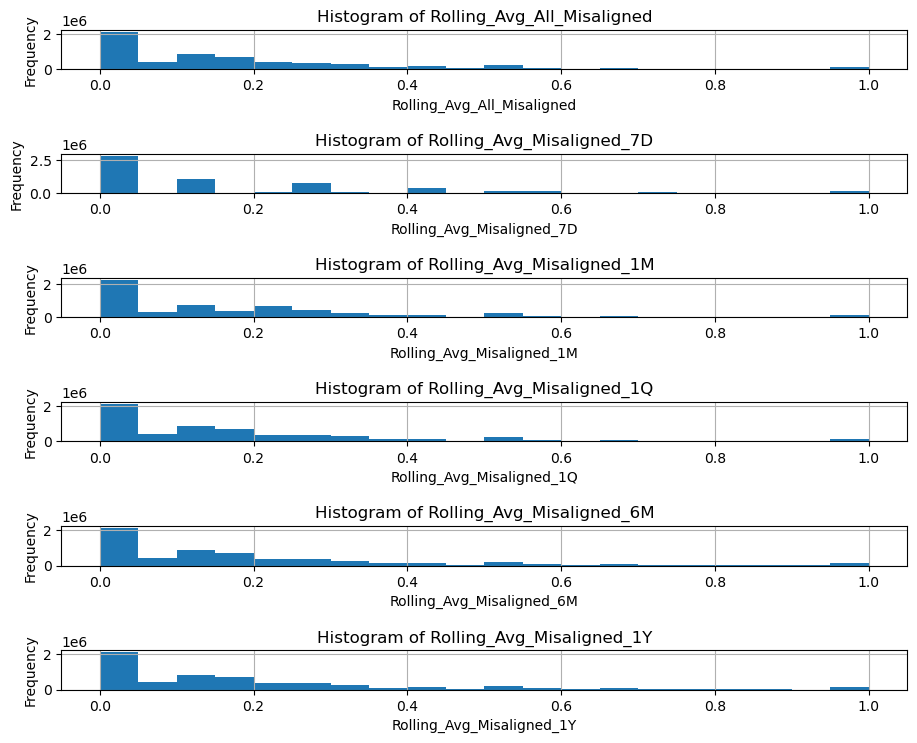

In [8]:
import matplotlib.pyplot as plt

# List of columns to check
columns_to_check = [
    'Rolling_Avg_All_Misaligned', 'Rolling_Avg_Misaligned_7D',
    'Rolling_Avg_Misaligned_1M', 'Rolling_Avg_Misaligned_1Q','Rolling_Avg_Misaligned_6M', 
    'Rolling_Avg_Misaligned_1Y'
]

# Display basic statistics for each column
print("Basic Statistics:\n")
print(data_clean[columns_to_check].describe())

# Display the number of unique values in each column
print("\nNumber of Unique Values:\n")
print(data_clean[columns_to_check].nunique())

# Plot histograms for each column
fig, axes = plt.subplots(nrows=len(columns_to_check), ncols=1, figsize=(10, 8))
fig.tight_layout(pad=4.0)

for i, col in enumerate(columns_to_check):
    data_clean[col].hist(ax=axes[i], bins=20)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

In [9]:
# Save the DataFrame to a pickle file
data_clean.to_pickle('data_room/pickle_files/data_clean.pkl')

In [ ]:
# Load 'data_clean' DataFrame from the pickle file
data_clean = pd.read_pickle('data_room/pickle_files/data_clean.pkl')

# Modelling

#### Column Refinement and Interaction Terms

In [23]:
# Create a copy of data_clean
data_clean_drop = data_clean.copy()

In [24]:
# Drop the 'title' and 'body' columns from data_clean_drop for file size
data_clean_drop = data_clean_drop.drop(columns=['title', 'body'])

In [25]:
# Generate dummy variables for the 'type' column
type_dummies = pd.get_dummies(data_clean_drop['type'], prefix='type').astype(int)  # Ensure the dummy columns are of integer type
# Rename only the columns of type_dummies to replace dashes with underscores
type_dummies.columns = [col.replace('-', '_') for col in type_dummies.columns]
# Add the renamed dummy variables to the data_clean_drop dataframe
data_clean_drop = pd.concat([data_clean_drop, type_dummies], axis=1)


In [26]:
#Display all columns headers in data_clean_drop
data_clean_drop.columns

Index(['voter', 'space_vote', 'created_vote', 'DAO_Creation_Date',
       'Blockchain_Network', 'Proposal_ID', 'Participated_Before',
       'Participated_in_previous_proposal', 'Total_Proposals_Participated',
       'Misaligned', 'Aligned', 'NotDetermined', 'voting_power',
       'log_voting_power', 'relative_voting_power',
       'log_relative_voting_power', 'duration_of_voting_period_days',
       'time_since_last_vote_days', 'size_of_dao', 'total_votes_on_proposal',
       'past_votes_within_dao_proposal', 'presence_in_other_daos',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'total_participation_rate', 'proposal_start_date', 'proposal_end_date',
       'Tenure_Upto_Proposal', 'type', 'choice', 'winning_choice', 'scores',
       'Voting_rule_delegation', 'Voting_rule_mixed', 'Cumulative_Misaligned',
       'Vote_Count', 'Rolling_Avg_All_Misaligned', 'days_since_earliest',
       'Rolling_Avg_Misaligned

In [27]:
import pandas as pd

# List of all time windows for which we need to generate interaction terms
time_windows = ['7D','1M','1Q','6M','1Y']

# List of additional factors we are interacting with
additional_factors = ['Voting_rule_delegation']

# List of voting types for which we need to generate interaction terms
voting_types = ['single_choice', 'weighted', 'quadratic', 'approval', 'ranked_choice']

# Loop through each time window to create interaction terms with the specified variables
for window in time_windows:
    for factor in additional_factors:
        data_clean_drop[f'Rolling_Avg_Misaligned_{window}_x_{factor}'] = data_clean_drop[f'Rolling_Avg_Misaligned_{window}'] * data_clean_drop[factor]
    
    for vtype in voting_types:
        data_clean_drop[f'Rolling_Avg_Misaligned_{window}_x_type_{vtype}'] = data_clean_drop[f'Rolling_Avg_Misaligned_{window}'] * data_clean_drop[f'type_{vtype}']

# Print the columns of data_clean_drop to verify that the new columns have been added 
print(data_clean_drop.columns)

Index(['voter', 'space_vote', 'created_vote', 'DAO_Creation_Date',
       'Blockchain_Network', 'Proposal_ID', 'Participated_Before',
       'Participated_in_previous_proposal', 'Total_Proposals_Participated',
       'Misaligned', 'Aligned', 'NotDetermined', 'voting_power',
       'log_voting_power', 'relative_voting_power',
       'log_relative_voting_power', 'duration_of_voting_period_days',
       'time_since_last_vote_days', 'size_of_dao', 'total_votes_on_proposal',
       'past_votes_within_dao_proposal', 'presence_in_other_daos',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'total_participation_rate', 'proposal_start_date', 'proposal_end_date',
       'Tenure_Upto_Proposal', 'type', 'choice', 'winning_choice', 'scores',
       'Voting_rule_delegation', 'Voting_rule_mixed', 'Cumulative_Misaligned',
       'Vote_Count', 'Rolling_Avg_All_Misaligned', 'days_since_earliest',
       'Rolling_Avg_Misaligned

In [28]:
import pandas as pd
from tabulate import tabulate

# Assuming 'data_clean_drop' is your DataFrame

# Renaming columns in the DataFrame
data_clean_drop.rename(columns={
    'Total_Proposals_Participated': 'total_decisions_participated',
    'Participated_in_previous_proposal': 'last_vote_previous_decision',
    'time_since_last_vote_days': 'time_since_last_vote',
    'duration_of_voting_period_days': 'voting_period_length',
    'Tenure_Upto_Proposal': 'voter_experience_days',
    'size_of_dao': 'organization_size',
    'presence_in_other_daos': 'presence_other_organizations',
    'total_votes_on_proposal': 'total_votes_decision'
}, inplace=True)

# Print the new column names to verify
print(data_clean_drop.columns)

Index(['voter', 'space_vote', 'created_vote', 'DAO_Creation_Date',
       'Blockchain_Network', 'Proposal_ID', 'Participated_Before',
       'last_vote_previous_decision', 'total_decisions_participated',
       'Misaligned', 'Aligned', 'NotDetermined', 'voting_power',
       'log_voting_power', 'relative_voting_power',
       'log_relative_voting_power', 'voting_period_length',
       'time_since_last_vote', 'organization_size', 'total_votes_decision',
       'past_votes_within_dao_proposal', 'presence_other_organizations',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'total_participation_rate', 'proposal_start_date', 'proposal_end_date',
       'voter_experience_days', 'type', 'choice', 'winning_choice', 'scores',
       'Voting_rule_delegation', 'Voting_rule_mixed', 'Cumulative_Misaligned',
       'Vote_Count', 'Rolling_Avg_All_Misaligned', 'days_since_earliest',
       'Rolling_Avg_Misaligned_7D', 'Roll

In [31]:
import pandas as pd
from tabulate import tabulate
# List of variables to extract for statistical analysis
variables = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

# Extracting the subset of the DataFrame
subset_data = data_clean_drop[variables]

# Compute the descriptive statistics
desc_stats = subset_data.describe().transpose()

# For binary variables, compute the percentage of observations that are 1
for column in subset_data.columns:
    if subset_data[column].nunique() == 2 and subset_data[column].isin([0,1]).all():
        percentage_ones = subset_data[column].mean() * 100
        desc_stats.at[column, 'Percentage (1s)'] = percentage_ones

# Select columns of interest and order them
cols_of_interest = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Percentage (1s)']
desc_stats = desc_stats[cols_of_interest]

# Using tabulate to display the table neatly
print(tabulate(desc_stats, headers='keys', tablefmt='grid', showindex=True, floatfmt=".2f"))

+--------------------------------------+------------+----------+----------+-------+---------+----------+----------+-----------+-------------------+
|                                      |      count |     mean |      std |   min |     25% |      50% |      75% |       max |   Percentage (1s) |
+======================================+============+==========+==========+=======+=========+==========+==========+===========+===================+
| Future_Voting_Participation_Proposal | 6032277.00 |     0.26 |     0.44 |  0.00 |    0.00 |     0.00 |     1.00 |      1.00 |             26.23 |
+--------------------------------------+------------+----------+----------+-------+---------+----------+----------+-----------+-------------------+
| Rolling_Avg_Misaligned_6M            | 6032277.00 |     0.18 |     0.22 |  0.00 |    0.00 |     0.13 |     0.25 |      1.00 |            nan    |
+--------------------------------------+------------+----------+----------+-------+---------+----------+--------

In [32]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# List of variables to extract for statistical analysis
variables = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

subset_data = data_clean_drop[variables]

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["variable"] = subset_data.columns
vif_data["VIF"] = [variance_inflation_factor(subset_data.values, i) for i in range(subset_data.shape[1])]

print(vif_data)


                                variable       VIF
0   Future_Voting_Participation_Proposal  1.381696
1              Rolling_Avg_Misaligned_6M  1.717659
2                 Voting_rule_delegation  1.185013
3                          type_weighted  1.106995
4                  relative_voting_power  1.027410
5           total_decisions_participated  2.122783
6            last_vote_previous_decision  4.218108
7                   time_since_last_vote  1.182030
8                   voting_period_length  1.424505
9                  voter_experience_days  2.403593
10                     organization_size  7.076441
11          presence_other_organizations  2.023354
12                  total_votes_decision  4.818004


In [33]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

subset_data = data_clean_drop[variables]

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["variable"] = subset_data.columns
vif_data["VIF"] = [variance_inflation_factor(subset_data.values, i) for i in range(subset_data.shape[1])]

# Calculating mean and highest VIF
mean_vif = vif_data["VIF"].mean()
max_vif = vif_data["VIF"].max()
max_vif_variable = vif_data.loc[vif_data["VIF"].idxmax(), "variable"]

print("Mean VIF:", mean_vif)
print("Highest VIF:", max_vif, "for variable:", max_vif_variable)


Mean VIF: 2.4375070935924237
Highest VIF: 7.076441477131352 for variable: organization_size


In [36]:
import pandas as pd

# Assuming 'desc_stats' is the DataFrame with your descriptive statistics
# This DataFrame should already be computed as shown in your previous message

# Saving the descriptive statistics DataFrame to an Excel file
output_file_path = 'docs/descriptive_statistics.xlsx'  # Replace with your desired file path
desc_stats.to_excel(output_file_path, index=True, float_format="%.2f")

print(f"Descriptive statistics saved to {output_file_path}")


Descriptive statistics saved to docs/descriptive_statistics.xlsx


                                      Future_Voting_Participation_Proposal  \
Future_Voting_Participation_Proposal                              1.000000   
Rolling_Avg_Misaligned_6M                                         0.024357   
Voting_rule_delegation                                            0.042268   
type_weighted                                                     0.140256   
relative_voting_power                                             0.012755   
total_decisions_participated                                     -0.118352   
last_vote_previous_decision                                      -0.001445   
time_since_last_vote                                              0.081765   
voting_period_length                                             -0.037389   
voter_experience_days                                             0.056686   
organization_size                                                -0.116992   
presence_other_organizations                                    

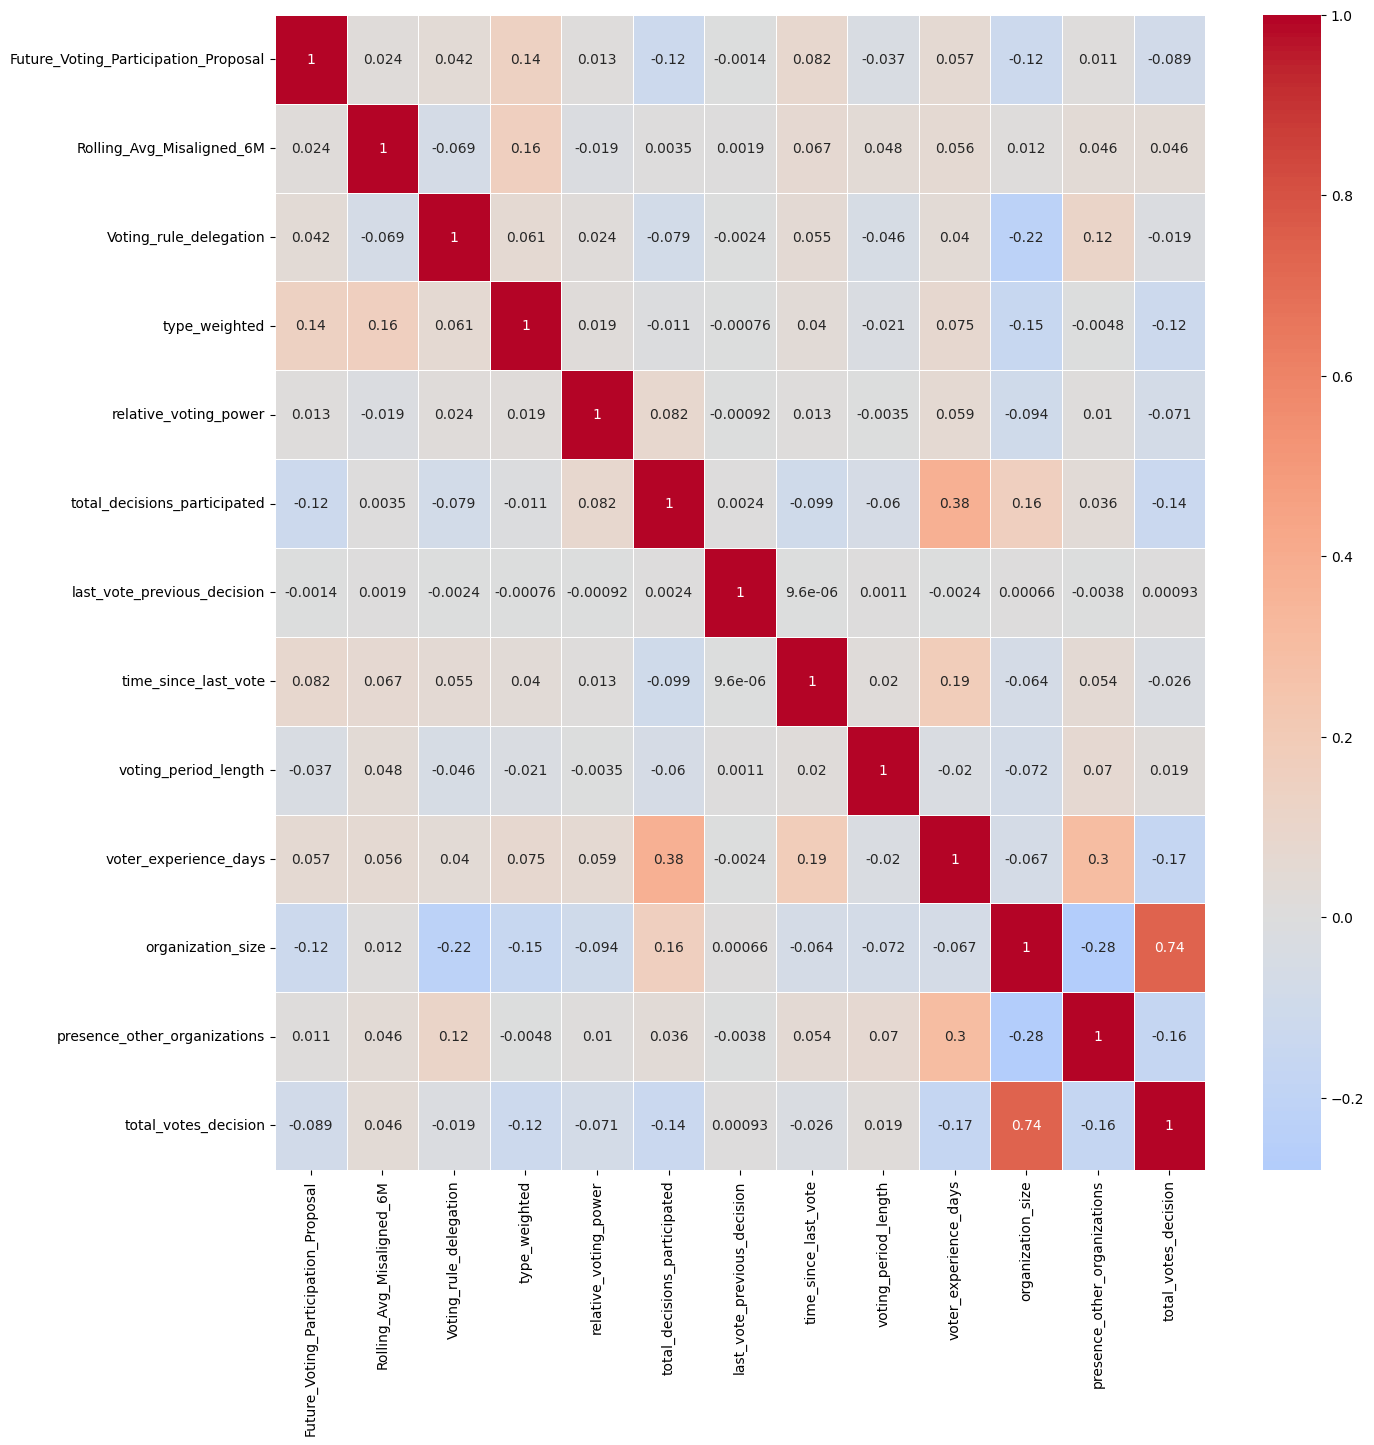

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data_clean_drop' is your cleaned DataFrame that contains the necessary columns.

variables = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

# Calculate the correlation matrix for the selected variables
correlation_matrix = data_clean_drop[variables].corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the matrix with a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.show()


In [38]:
import pandas as pd

# Assuming 'data_clean_drop' is your cleaned DataFrame that contains the necessary columns.

variables = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

# Calculate the correlation matrix for the selected variables
correlation_matrix = data_clean_drop[variables].corr()

# Exporting the correlation matrix to an Excel file
output_file_path = 'docs/correlation_matrix.xlsx'  # Replace with your desired file path
correlation_matrix.to_excel(output_file_path)

print(f"Correlation matrix saved to {output_file_path}")


Correlation matrix saved to docs/correlation_matrix.xlsx


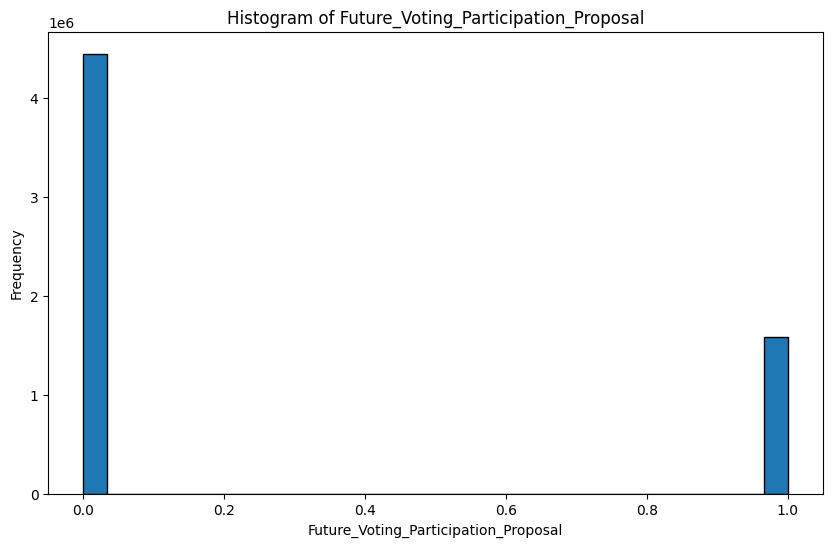

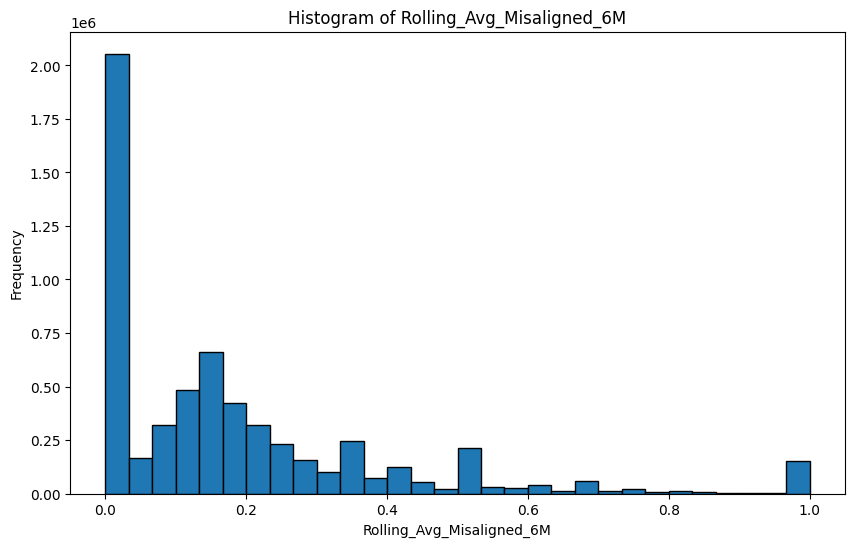

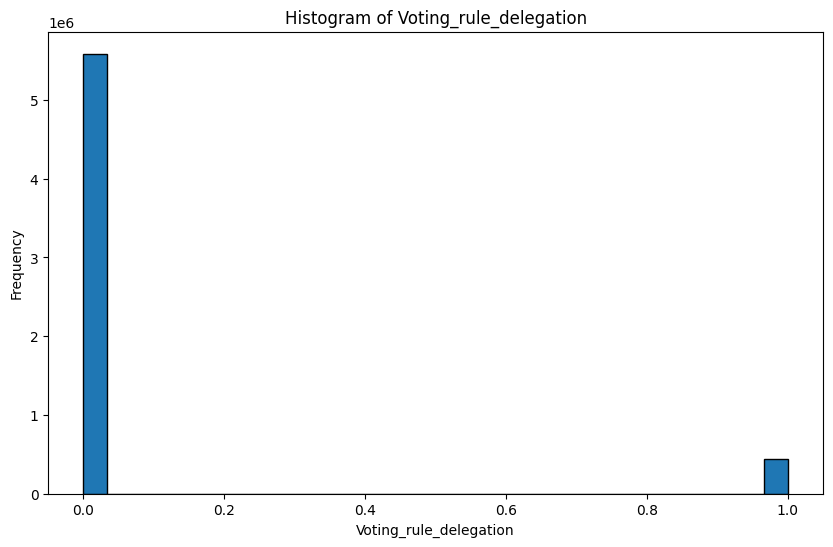

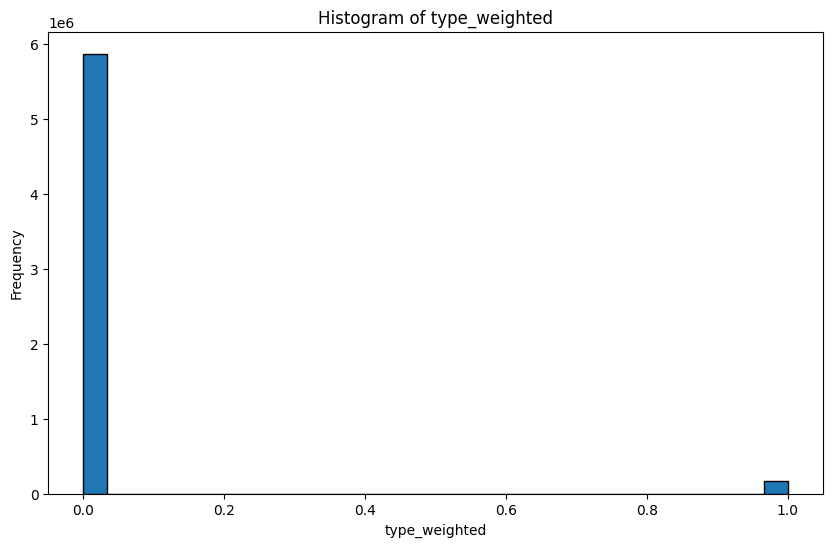

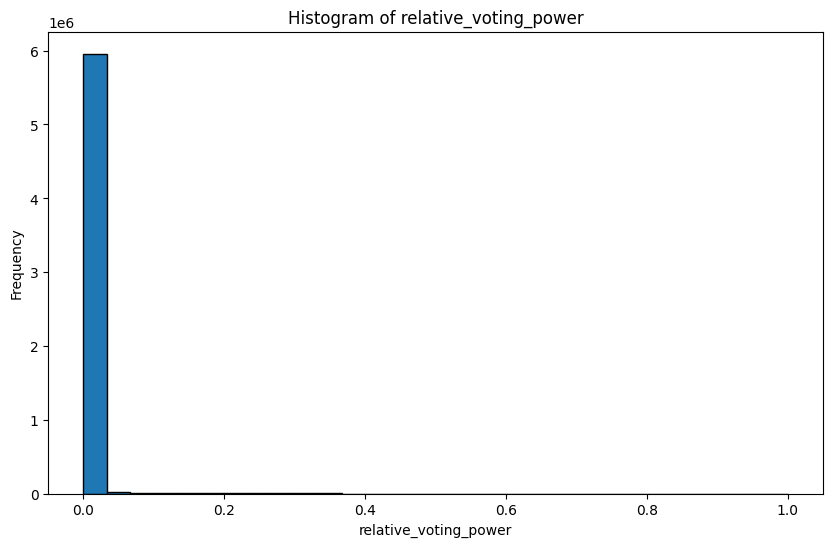

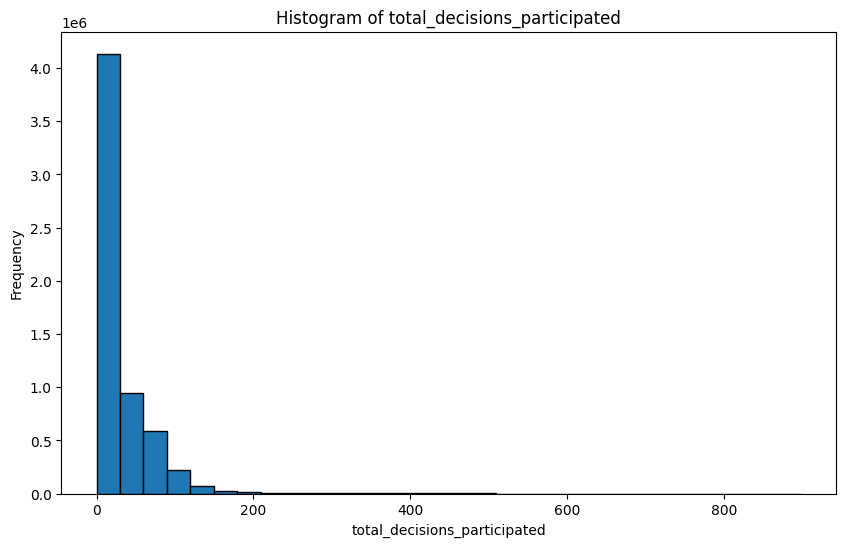

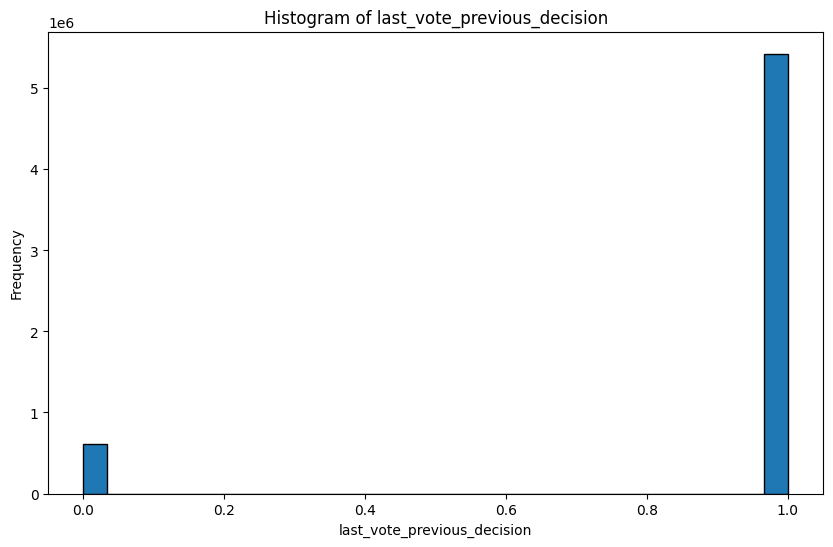

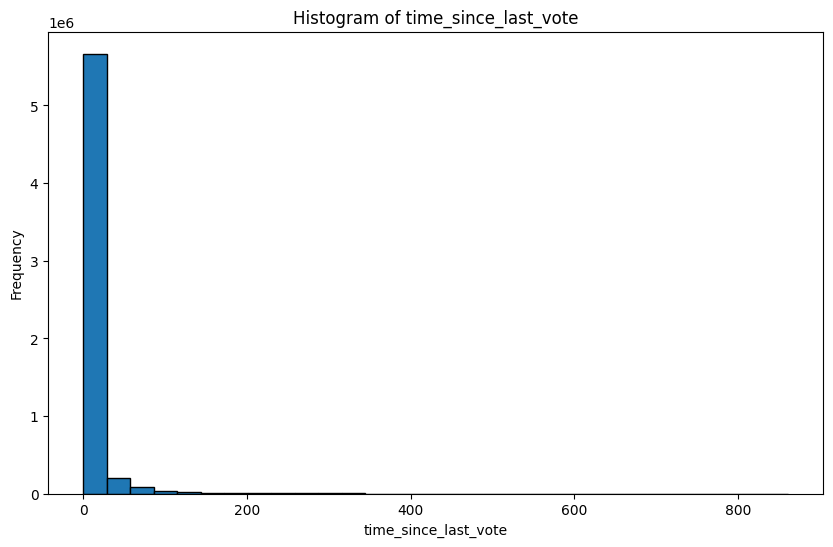

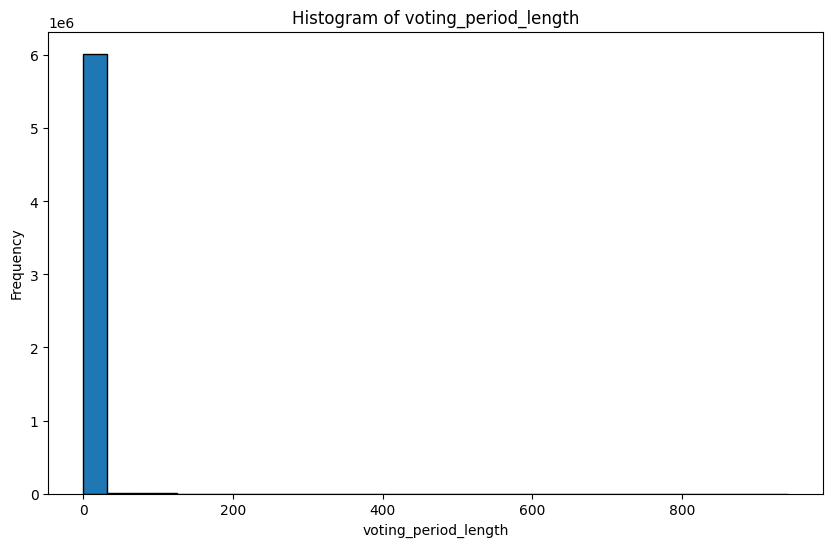

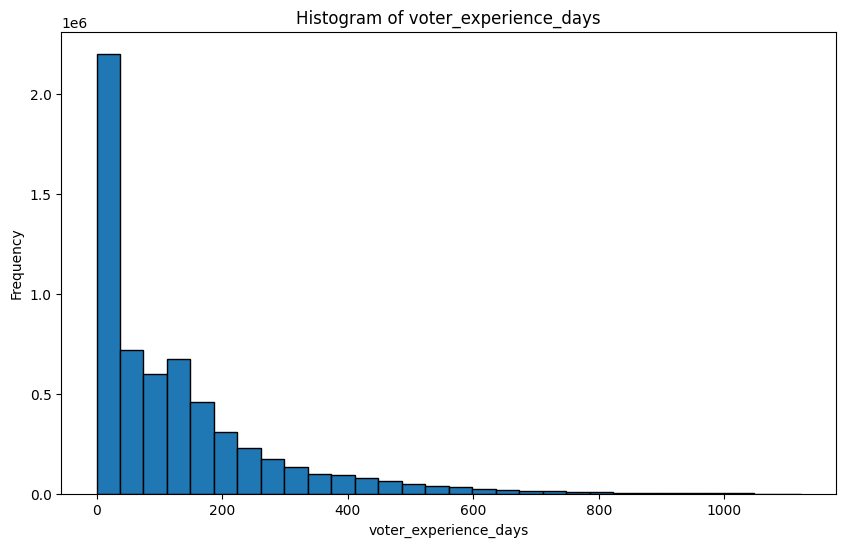

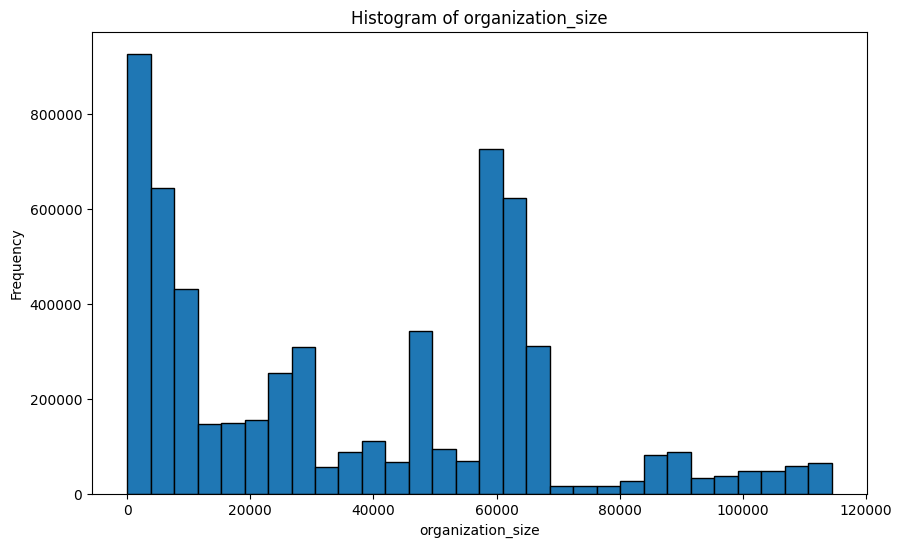

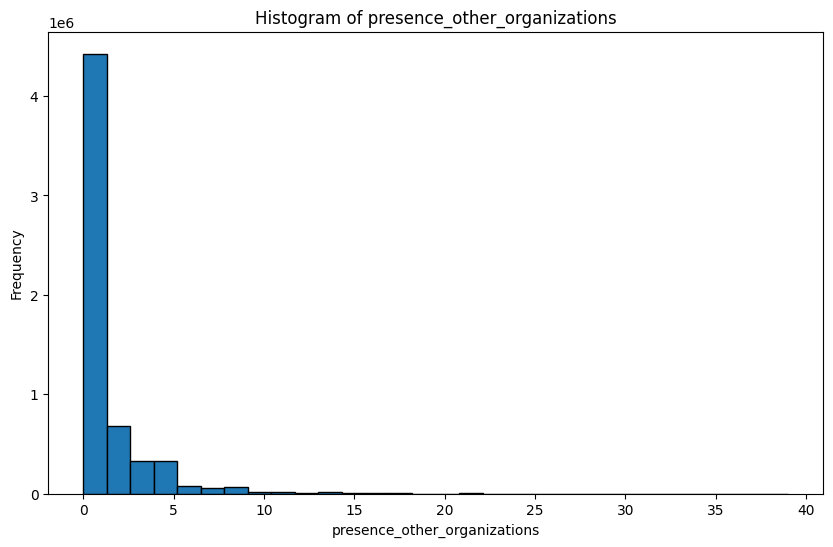

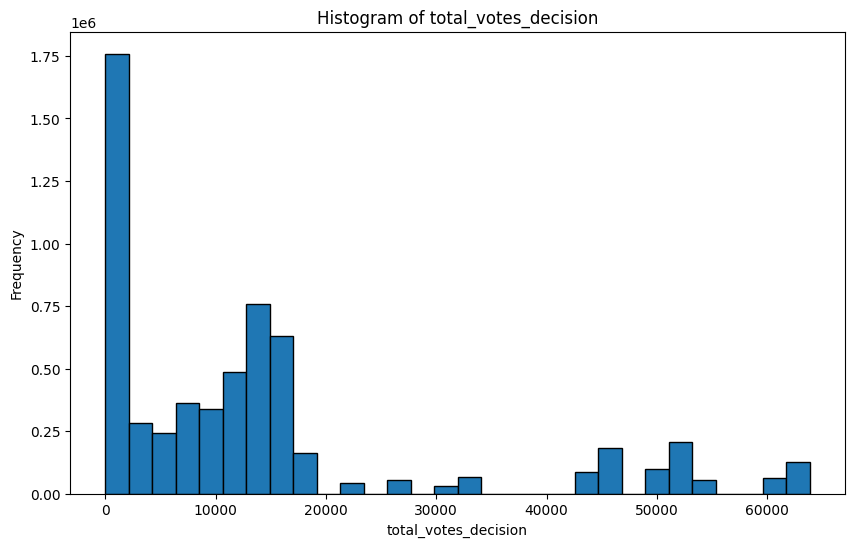

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# List of all columns for which you want to plot histograms
columns = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

def plot_histograms(df, columns):
    for column in columns:
        plt.figure(figsize=(10,6))
        plt.hist(df[column], bins=30, edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

# Call the function with your DataFrame and list of columns
plot_histograms(data_clean_drop, columns)


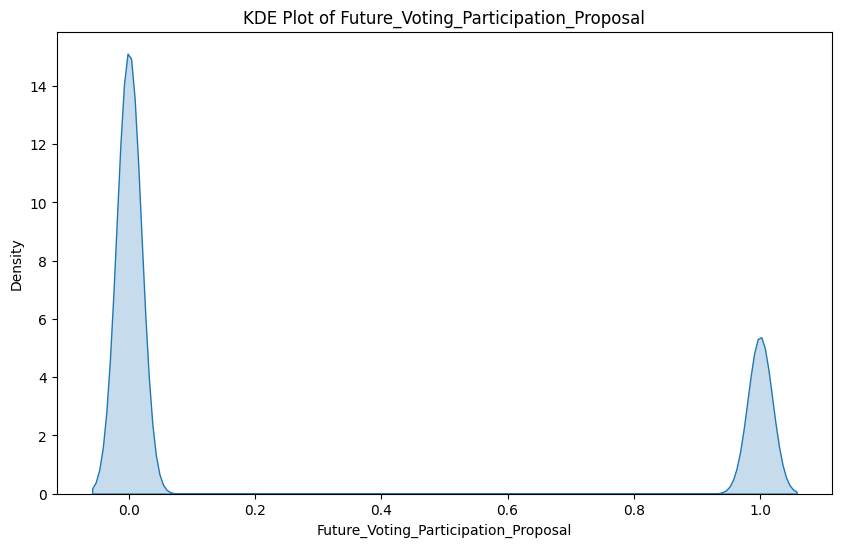

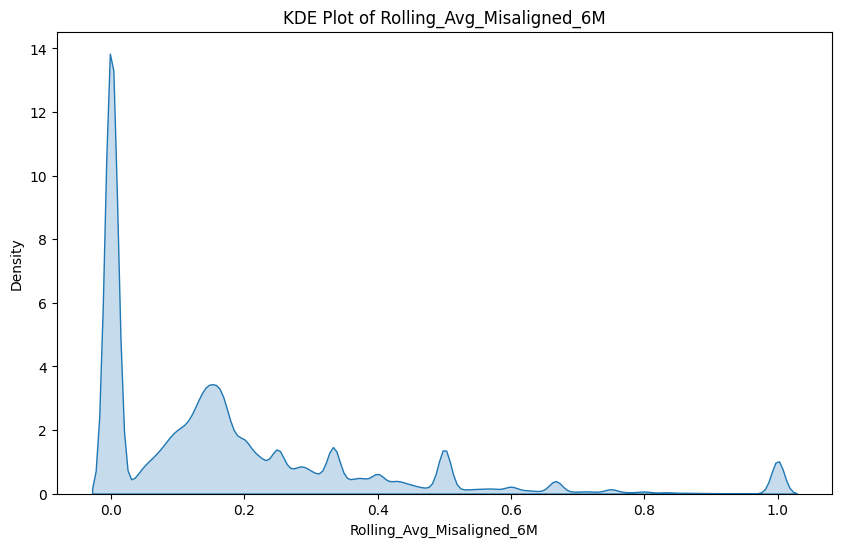

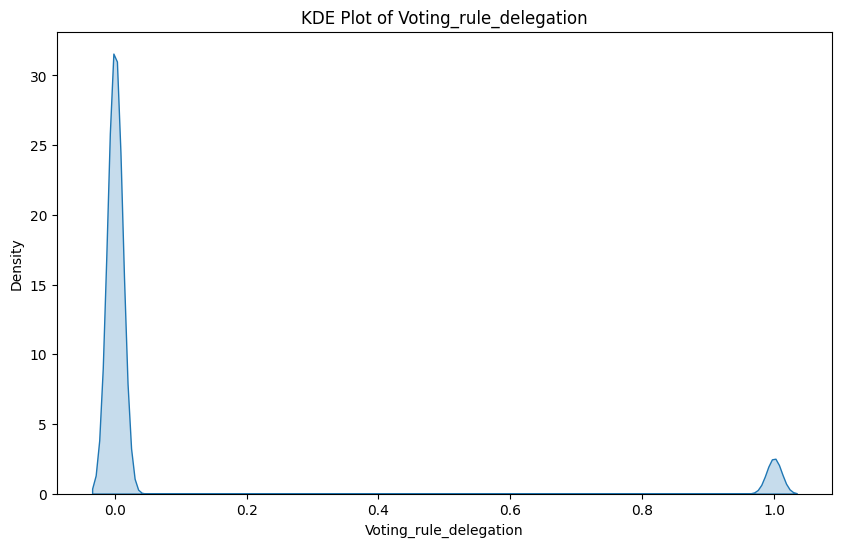

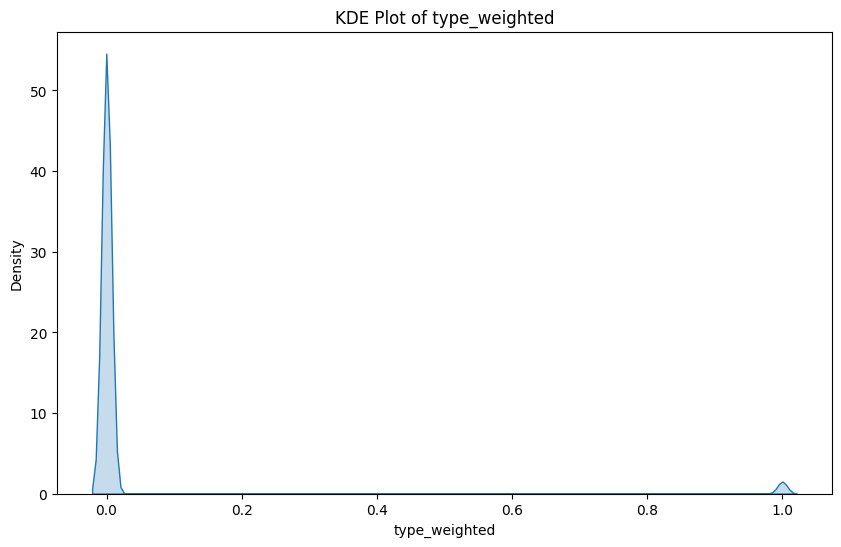

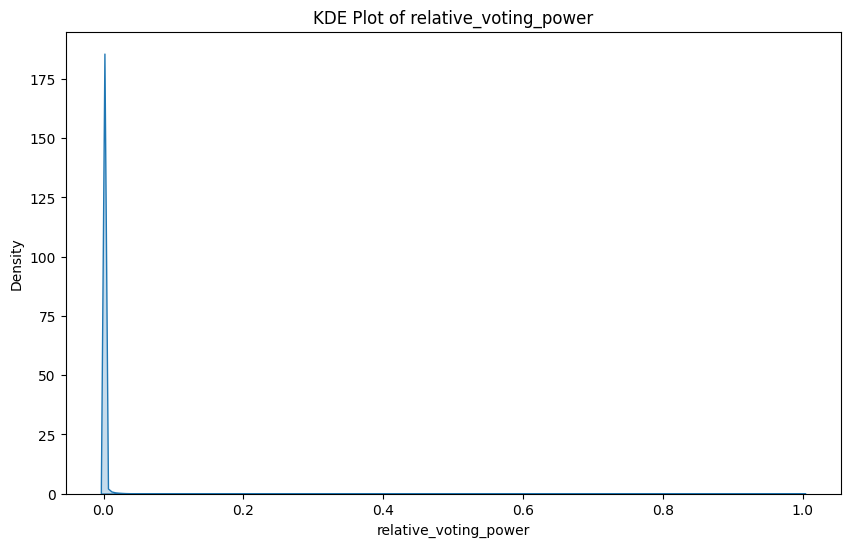

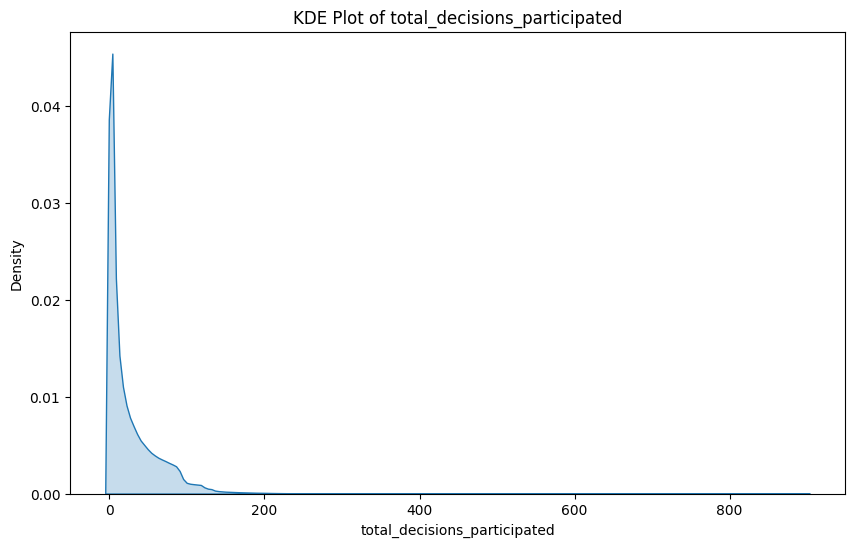

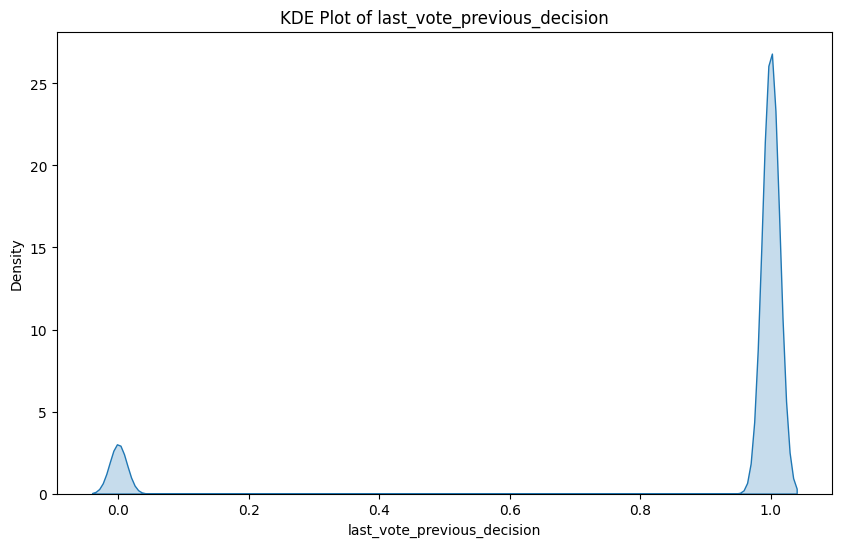

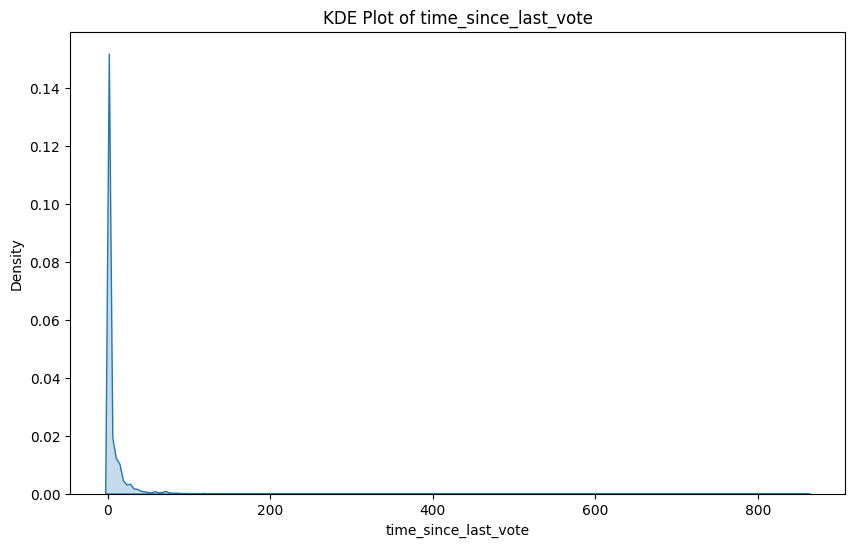

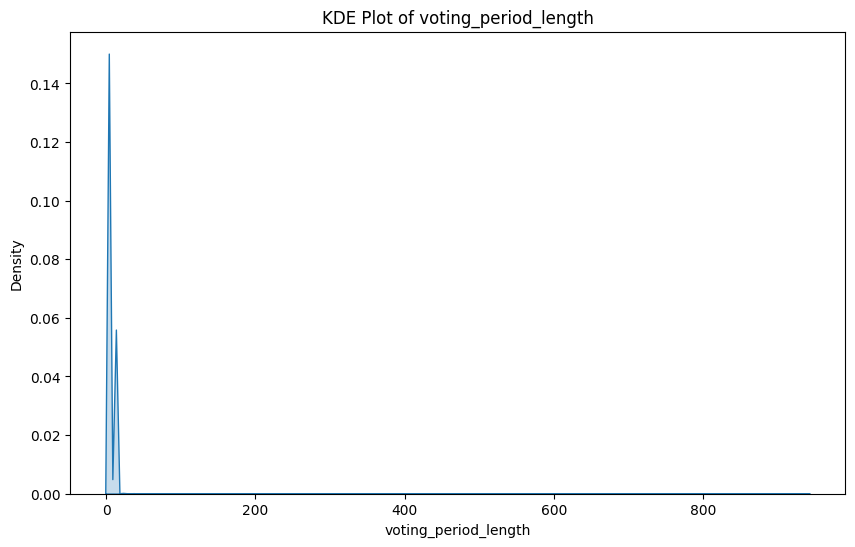

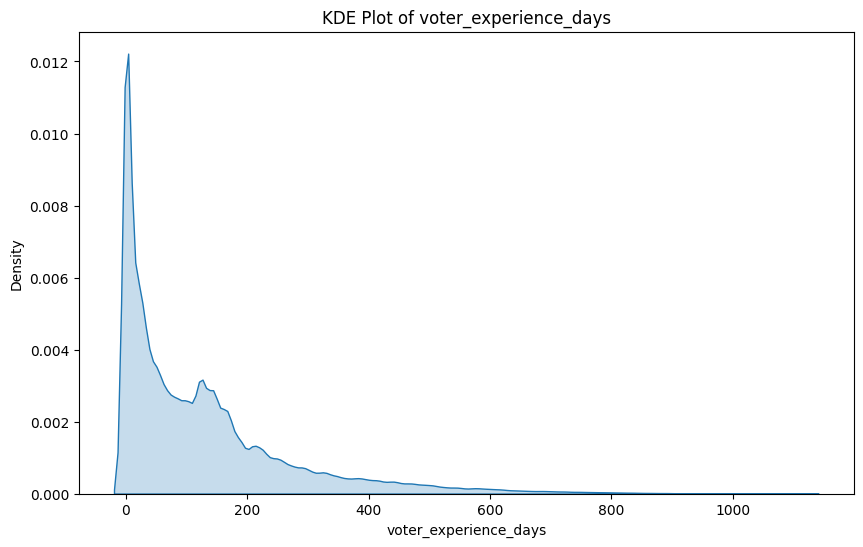

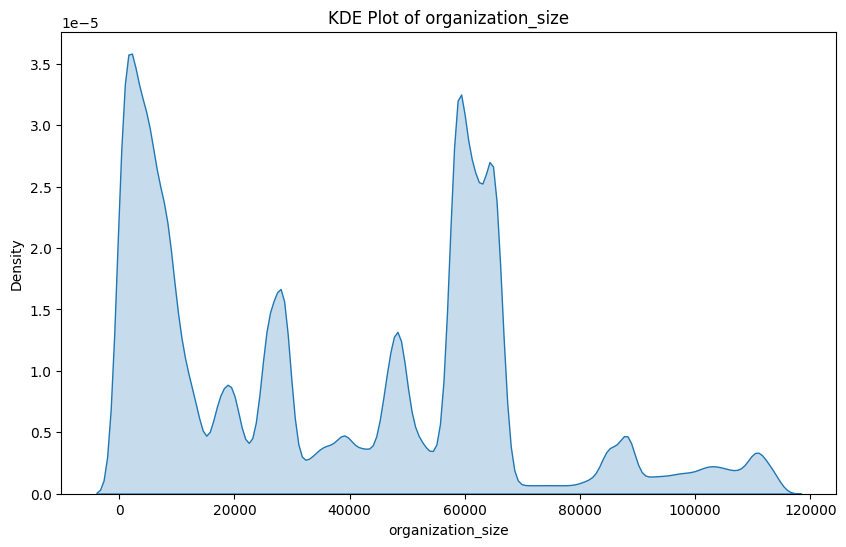

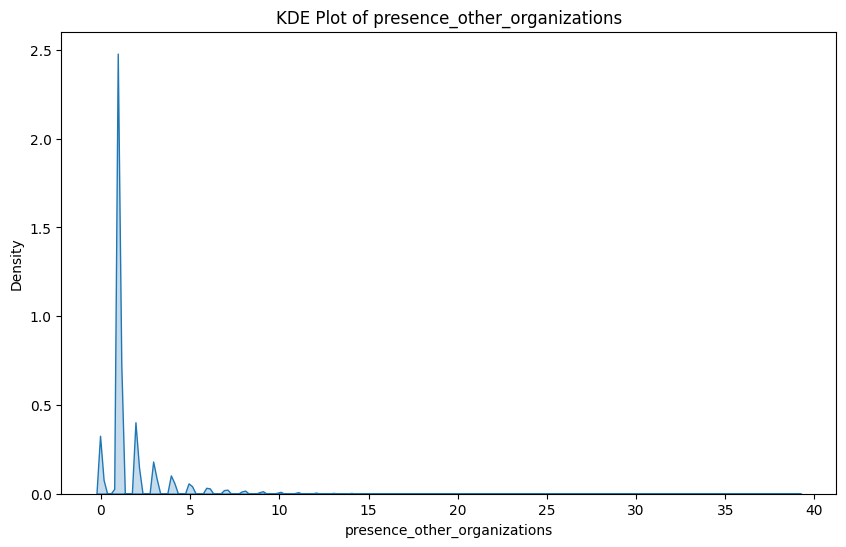

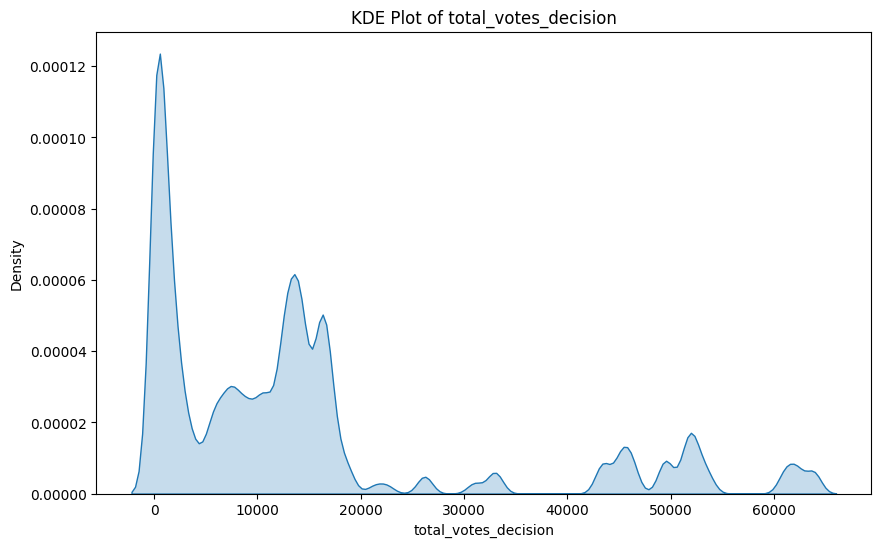

In [40]:
import pandas as pd
import seaborn as sns

columns = [
    'Future_Voting_Participation_Proposal',
    'Rolling_Avg_Misaligned_6M',
    'Voting_rule_delegation',
    'type_weighted',
    'relative_voting_power',
    'total_decisions_participated',
    'last_vote_previous_decision',
    'time_since_last_vote',
    'voting_period_length',
    'voter_experience_days',
    'organization_size',
    'presence_other_organizations',
    'total_votes_decision'
]

def plot_kde(df, columns):
    for column in columns:
        plt.figure(figsize=(10,6))
        sns.kdeplot(df[column], fill=True)
        plt.title(f'KDE Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.show()

# Call the function with your DataFrame and list of columns
plot_kde(data_clean_drop, columns)


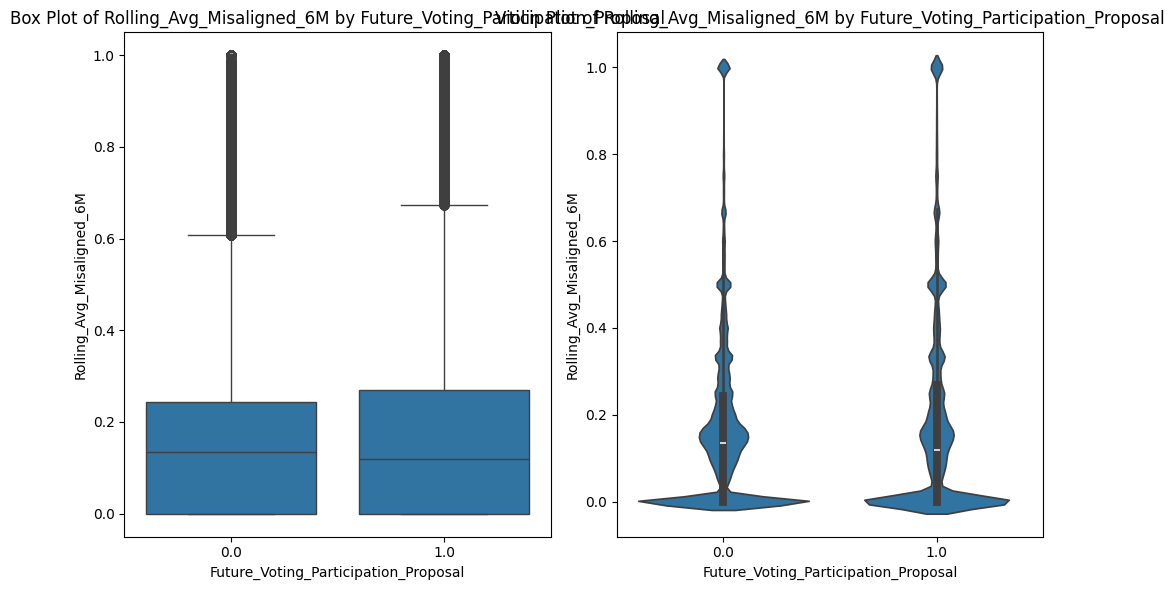

In [41]:
import pandas as pd
import seaborn as sns

# List of binary columns for which you want to plot
binary_columns = ['Future_Voting_Participation_Proposal']

# Assume 'continuous_var' is your continuous variable
continuous_var = 'Rolling_Avg_Misaligned_6M'

def plot_binary(df, binary_columns, continuous_var):
    for column in binary_columns:
        plt.figure(figsize=(10,6))
        
        # Box plot
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[column], y=df[continuous_var])
        plt.title(f'Box Plot of {continuous_var} by {column}')
        
        # Violin plot
        plt.subplot(1, 2, 2)
        sns.violinplot(x=df[column], y=df[continuous_var])
        plt.title(f'Violin Plot of {continuous_var} by {column}')
        
        plt.tight_layout()
        plt.show()

# Call the function with your DataFrame and list of columns
plot_binary(data_clean_drop, binary_columns, continuous_var)


In [42]:
# Save the DataFrame to a pickle file
data_clean_drop.to_pickle('data_room/pickle_files/data_clean_drop.pkl')

In [43]:
# Load 'data_clean_drop' DataFrame from the pickle file
data_clean_drop = pd.read_pickle('data_room/pickle_files/data_clean_drop.pkl')

### Exploring Dataset

In [44]:
import pandas as pd
from scipy import stats
# Ensure 'created_vote' is in pandas datetime format
data_clean_drop['created_vote'] = pd.to_datetime(data_clean_drop['created_vote'])
# Count the total number of unique voters
total_unique_voters = data_clean_drop['voter'].nunique()
# Voter who participated in the most number of decisions
most_active_voter = data_clean_drop['voter'].value_counts().idxmax()
# Total number of decisions
total_proposals = data_clean_drop['Proposal_ID'].nunique()
# Decision with the most votes
most_voted_proposal = data_clean_drop['Proposal_ID'].value_counts().idxmax()
# Total number of unique organizations
total_dao_spaces = data_clean_drop['space_vote'].nunique()
# Organization with the most decisions
most_proposals_space = data_clean_drop['space_vote'].value_counts().idxmax()
# Average likelihood of someone participating in future decisions
average_participation = data_clean_drop['Future_Voting_Participation_Proposal'].mean()
# Average voting power of the voters
avg_voting_power = data_clean_drop['voting_power'].mean()
# Average log voting power of the voters
avg_log_voting_power = data_clean_drop['log_voting_power'].mean()
# Average duration of voting periods
avg_voting_period_duration = data_clean_drop['voting_period_length'].mean()
# Average time since the last vote
avg_time_since_last_vote = data_clean_drop['time_since_last_vote'].mean()
# Total number of voters who have participated before
voters_participated_before = data_clean_drop[data_clean_drop['last_vote_previous_decision'] == 1]['voter'].nunique()
# Organization with the maximum size
largest_dao_space = data_clean_drop.groupby('space_vote')['organization_size'].max().idxmax()
# Total voters who have a presence in other organizations
voters_in_other_daos = data_clean_drop[data_clean_drop['presence_other_organizations'] == 1]['voter'].nunique()
# Average experience of voters up to the decision
avg_tenure_upto_proposal = data_clean_drop['voter_experience_days'].mean()
# Number of decisions using different voting types
voting_types = ['type_approval', 'type_basic', 'type_quadratic', 'type_ranked_choice', 'type_single_choice', 'type_weighted','Voting_rule_delegation']
voting_type_counts = data_clean_drop[voting_types].sum()
# Calculate votes per voter per month
votes_per_voter_per_month = data_clean_drop.groupby(['voter', data_clean_drop['created_vote'].dt.to_period('M')]).size().reset_index(name='votes_per_month')
# Calculate the overall average number of votes per voter per month (mean)
overall_average_votes_per_voter_per_month = votes_per_voter_per_month['votes_per_month'].mean()
# Calculate the median number of votes per voter per month
median_votes_per_voter_per_month = votes_per_voter_per_month['votes_per_month'].median()
# Calculate the mode number of votes per voter per month
mode_votes_per_voter_per_month = votes_per_voter_per_month['votes_per_month'].mode()[0]
# Decisions per DAO per month
decisions_per_dao_per_month = data_clean_drop.groupby(['space_vote', data_clean_drop['created_vote'].dt.to_period('M')]).size().reset_index(name='decisions_per_month')
# Calculate the average number of decisions per DAO per month
average_decisions_per_dao_per_month = decisions_per_dao_per_month.groupby('space_vote')['decisions_per_month'].mean().reset_index(name='average_decisions_per_month')

# Output the results
print("Total number of unique voters: ", total_unique_voters)
print("Voter who participated in the most number of decisions: ", most_active_voter)
print("Total number of decisions: ", total_proposals)
print("Decision with the most votes: ", most_voted_proposal)
print("Total number of organizations: ", total_dao_spaces)
print("Organization with the most decisions: ", most_proposals_space)
print("Average likelihood of someone participating in future decisions: ", average_participation)
print("\nNumber of decisions using different voting types:")
for vote_type, count in voting_type_counts.items():
    print(f"{vote_type}: {count}")
print("\nAverage voting power of the voters: ", avg_voting_power)
print("Average log voting power of the voters: ", avg_log_voting_power)
print("Average duration of voting periods: ", avg_voting_period_duration)
print("Average time since the last vote: ", avg_time_since_last_vote)
print("Total number of voters who have participated before: ", voters_participated_before)
print("Organization with the largest size: ", largest_dao_space)
print("Total voters who have a presence in other organizations: ", voters_in_other_daos)
print("Average experience of voters up to the decision: ", avg_tenure_upto_proposal)
print("Overall average number of votes per voter per month (mean): ", overall_average_votes_per_voter_per_month)
print("Median number of votes per voter per month: ", median_votes_per_voter_per_month)
print("Mode number of votes per voter per month: ", mode_votes_per_voter_per_month)
print("\nAverage number of decisions per DAO per month:")
print(average_decisions_per_dao_per_month)









Total number of unique voters:  487816
Voter who participated in the most number of decisions:  0xD03Ad690ed8065EDfdC1E08197a3ebC71535A7ff
Total number of decisions:  14416
Decision with the most votes:  0xa9457a5344747a6c272de786419fc7a4e83fcf0f927ef9b1ce767452faa9b453
Total number of organizations:  171
Organization with the most decisions:  aave.eth
Average likelihood of someone participating in future decisions:  0.2622682943770652

Number of decisions using different voting types:
type_approval: 252493
type_basic: 1660161
type_quadratic: 19580
type_ranked_choice: 12937
type_single_choice: 3925744
type_weighted: 161362
Voting_rule_delegation: 442991

Average voting power of the voters:  1488345809.848962
Average log voting power of the voters:  2.075575922424662
Average duration of voting periods:  5.659872042310588
Average time since the last vote:  7.32412932397721
Total number of voters who have participated before:  467443
Organization with the largest size:  arbitrumfoundation

In [45]:
import pandas as pd
# Group by 'space_vote' and the month of 'created_vote', then count the number of decisions
decisions_per_dao_per_month = data_clean_drop.groupby(['space_vote', data_clean_drop['created_vote'].dt.to_period('M')]).size().reset_index(name='number_of_decisions')

# Display the results
print(decisions_per_dao_per_month)

          space_vote created_vote  number_of_decisions
0          1inch.eth      2022-01                   13
1          1inch.eth      2022-02                   22
2          1inch.eth      2022-03                   23
3          1inch.eth      2022-05                   54
4          1inch.eth      2022-07                  118
...              ...          ...                  ...
2206  younghwang.eth      2022-06                 2059
2207  younghwang.eth      2022-10                  200
2208  younghwang.eth      2022-11                 1072
2209  younghwang.eth      2022-12                   35
2210  younghwang.eth      2023-02                  653

[2211 rows x 3 columns]


In [46]:
import pandas as pd

# Assuming 'data_clean_drop' is your DataFrame that contains the necessary columns.

# Calculate the total votes for each DAO space and sort them
top_dao_spaces_by_votes = data_clean_drop['space_vote'].value_counts().head(5).reset_index()
top_dao_spaces_by_votes.columns = ['DAO_Space', 'Total_Votes']

# Display the top 5 DAO spaces by total votes
print("Top 5 DAO spaces by total votes:")
print(top_dao_spaces_by_votes)


Top 5 DAO spaces by total votes:
                DAO_Space  Total_Votes
0                aave.eth      2336566
1        opcollective.eth      1144456
2  arbitrumfoundation.eth       578331
3        snapshot.dcl.eth       131374
4              stgdao.eth       129826


In [47]:
import pandas as pd

# Assuming 'data_clean_drop' is your cleaned DataFrame that contains the necessary columns.

# Count the number of votes for each DAO space
dao_space_activity = data_clean_drop['space_vote'].value_counts()

# Convert this to a DataFrame for better visualization and to add column names
dao_space_activity_df = dao_space_activity.reset_index()
dao_space_activity_df.columns = ['DAO_Space', 'Number_of_votes']

# Display the most active DAO spaces
print("List of DAO spaces by activity:")
print(dao_space_activity_df)

# If you want to display only the top 10 most active DAO spaces
print("\nTop 10 most active DAO spaces:")
print(dao_space_activity_df.head(10))


List of DAO spaces by activity:
                        DAO_Space  Number_of_votes
0                        aave.eth          2336566
1                opcollective.eth          1144456
2          arbitrumfoundation.eth           578331
3                snapshot.dcl.eth           131374
4                      stgdao.eth           129826
..                            ...              ...
166             ampleforthorg.eth               57
167                barnbridge.eth               36
168                 raidparty.eth               19
169             cream-finance.eth               19
170  squiggledaotreasurysquad.eth               18

[171 rows x 2 columns]

Top 10 most active DAO spaces:
                DAO_Space  Number_of_votes
0                aave.eth          2336566
1        opcollective.eth          1144456
2  arbitrumfoundation.eth           578331
3        snapshot.dcl.eth           131374
4              stgdao.eth           129826
5            balancer.eth           114593

In [48]:
# Define the voting types we are interested in
voting_types = ['type_basic', 'type_single_choice', 'type_weighted', 'type_quadratic', 'type_approval', 'type_ranked_choice']

# Print the times each specified voting type was introduced
print("Introduction times for each specified voting type:")
for vote_type in voting_types:
    first_occurrence = data_clean_drop[data_clean_drop[vote_type] == True]['created_vote'].min()
    print(f"{vote_type}: {first_occurrence}")


Introduction times for each specified voting type:
type_basic: 2021-11-03 19:06:50
type_single_choice: 2020-07-18 16:12:04
type_weighted: 2021-06-24 10:14:03
type_quadratic: 2021-07-27 00:06:28
type_approval: 2021-06-09 00:05:47
type_ranked_choice: 2021-06-28 12:55:52


## Panel OLS

### Entity (voter and created_vote) fixed effects

Index(['voter', 'space_vote', 'created_vote', 'DAO_Creation_Date',
       'Blockchain_Network', 'Proposal_ID', 'Participated_Before',
       'last_vote_previous_decision', 'total_decisions_participated',
       'Misaligned', 'Aligned', 'NotDetermined', 'voting_power',
       'log_voting_power', 'relative_voting_power',
       'log_relative_voting_power', 'voting_period_length',
       'time_since_last_vote', 'organization_size', 'total_votes_decision',
       'past_votes_within_dao_proposal', 'presence_other_organizations',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'total_participation_rate', 'proposal_start_date', 'proposal_end_date',
       'voter_experience_days', 'type', 'choice', 'winning_choice', 'scores',
       'Voting_rule_delegation', 'Voting_rule_mixed', 'Cumulative_Misaligned',
       'Vote_Count', 'Rolling_Avg_All_Misaligned', 'days_since_earliest',
       'Rolling_Avg_Misaligned_7D', 'Rolling_Avg_Misaligned_1M',
       'Rolling_Avg_Misaligned_1Q', 'Rolling_Avg_Misaligned_6M',
       'Rolling_Avg_Misaligned_1Y', 'Total_Misaligned_Votes', 'Total_Votes',
       'Misalignment_Rate', 'type_approval', 'type_basic', 'type_quadratic',
       'type_ranked_choice', 'type_single_choice', 'type_weighted',
       'Rolling_Avg_Misaligned_7D_x_Voting_rule_delegation',
       'Rolling_Avg_Misaligned_7D_x_type_single_choice',
       'Rolling_Avg_Misaligned_7D_x_type_weighted',
       'Rolling_Avg_Misaligned_7D_x_type_quadratic',
       'Rolling_Avg_Misaligned_7D_x_type_approval',
       'Rolling_Avg_Misaligned_7D_x_type_ranked_choice',
       'Rolling_Avg_Misaligned_1M_x_Voting_rule_delegation',
       'Rolling_Avg_Misaligned_1M_x_type_single_choice',
       'Rolling_Avg_Misaligned_1M_x_type_weighted',
       'Rolling_Avg_Misaligned_1M_x_type_quadratic',
       'Rolling_Avg_Misaligned_1M_x_type_approval',
       'Rolling_Avg_Misaligned_1M_x_type_ranked_choice',
       'Rolling_Avg_Misaligned_1Q_x_Voting_rule_delegation',
       'Rolling_Avg_Misaligned_1Q_x_type_single_choice',
       'Rolling_Avg_Misaligned_1Q_x_type_weighted',
       'Rolling_Avg_Misaligned_1Q_x_type_quadratic',
       'Rolling_Avg_Misaligned_1Q_x_type_approval',
       'Rolling_Avg_Misaligned_1Q_x_type_ranked_choice',
       'Rolling_Avg_Misaligned_6M_x_Voting_rule_delegation',
       'Rolling_Avg_Misaligned_6M_x_type_single_choice',
       'Rolling_Avg_Misaligned_6M_x_type_weighted',
       'Rolling_Avg_Misaligned_6M_x_type_quadratic',
       'Rolling_Avg_Misaligned_6M_x_type_approval',
       'Rolling_Avg_Misaligned_6M_x_type_ranked_choice',
       'Rolling_Avg_Misaligned_1Y_x_Voting_rule_delegation',
       'Rolling_Avg_Misaligned_1Y_x_type_single_choice',
       'Rolling_Avg_Misaligned_1Y_x_type_weighted',
       'Rolling_Avg_Misaligned_1Y_x_type_quadratic',
       'Rolling_Avg_Misaligned_1Y_x_type_approval',
       'Rolling_Avg_Misaligned_1Y_x_type_ranked_choice'],
      dtype='object')

In [62]:
from linearmodels import PanelOLS
import pandas as pd
from scipy.stats import pearsonr

# Reset index if 'voter' is not in columns but exists in index
if 'voter' not in data_clean_drop.columns and 'voter' in data_clean_drop.index.names:
    data_clean_drop.reset_index(inplace=True)
# Convert 'created_vote' to datetime if it's not already
data_clean_drop.loc[:, 'created_vote'] = pd.to_datetime(data_clean_drop['created_vote'])
# Create 'year_month' only if it doesn't already exist
if 'year_month' not in data_clean_drop.columns:
    data_clean_drop['year_month'] = data_clean_drop['created_vote'].dt.to_period('M').dt.to_timestamp()
# Set 'voter' and 'year_month' as index
data_clean_drop.set_index(['voter', 'year_month'], inplace=True)
# Select only numerical columns
data_clean_numeric = data_clean_drop.select_dtypes(include=['number'])

# Function to compute correlation-based R^2
def compute_correlation_based_R2(results, df):
    # Extracting predicted values
    df['y_pred'] = results.predict().values
    
    # Between R^2 (correlation method)
    grouped = df.groupby(level='voter')
    y_bar = grouped['Future_Voting_Participation_Proposal'].transform('mean')
    x_bar = grouped['y_pred'].transform('mean')
    rho_B2 = pearsonr(x_bar, y_bar)[0] ** 2
    
    # Overall R^2 (correlation method)
    rho_O2 = pearsonr(df['y_pred'], df['Future_Voting_Participation_Proposal'])[0] ** 2
    
    # Within R^2 (correlation method)
    x_demeaned = df['y_pred'] - df['y_pred'].groupby(level='voter').transform('mean')
    y_demeaned = df['Future_Voting_Participation_Proposal'] - df['Future_Voting_Participation_Proposal'].groupby(level='voter').transform('mean')
    rho_W2 = pearsonr(x_demeaned, y_demeaned)[0] ** 2
    
    return rho_B2, rho_O2, rho_W2

# Define a two-way fixed effects model formula, adding new variables
formula = """
Future_Voting_Participation_Proposal ~ 1
+ Rolling_Avg_Misaligned_6M
+ relative_voting_power
+ total_decisions_participated
+ last_vote_previous_decision
+ time_since_last_vote
+ voting_period_length
+ voter_experience_days
+ organization_size
+ presence_other_organizations
+ total_votes_decision
+ EntityEffects
+ TimeEffects
"""

# Run the PanelOLS regression
mod = PanelOLS.from_formula(formula, data=data_clean_numeric, drop_absorbed=True)

res = mod.fit(cov_type='clustered', cluster_entity=True, low_memory=False)

try:
    # Compute correlation-based R^2 values
    rho_B2, rho_O2, rho_W2 = compute_correlation_based_R2(res, data_clean_numeric)
    
    # Print the results and the correlation-based R^2 values
    print(res)
    print("Between R^2 (correlation method):", rho_B2)
    print("Within R^2 (correlation method):", rho_W2)
    print("Overall R^2 (correlation method):", rho_O2)
    
except Exception as e:
    print(f"Error in model fitting: {e}")

# E.g., other columns: 
    # + type_weighted
    # + Rolling_Avg_Misaligned_6M_x_Voting_rule_delegation
    # + Rolling_Avg_Misaligned_6M_x_type_weighted
    # + Rolling_Avg_Misaligned_6M_x_type_quadratic
    # + Rolling_Avg_Misaligned_6M_x_type_ranked_choice
    # + Rolling_Avg_Misaligned_6M_x_type_approval
    # + Governance
    # + Rolling_Avg_Misaligned_6M
    # + Rolling_Avg_Misaligned_6M_x_type_ranked_choice
    # + type_quadratic
    # + type_approval
    # + type_ranked_choice
    # + type_weighted
    # + Rolling_Avg_Misaligned_1M_x_Voting_rule_delegation
    # + Rolling_Avg_Misaligned_1M_x_type_weighted

# Reset the index (to access voter and year_month as columns)
data_clean_drop.reset_index(inplace=True)

                                   PanelOLS Estimation Summary                                    
Dep. Variable:     Future_Voting_Participation_Proposal   R-squared:                        0.0172
Estimator:                                     PanelOLS   R-squared (Between):             -1.0881
No. Observations:                               6032277   R-squared (Within):              -0.0462
Date:                                  Mon, May 27 2024   R-squared (Overall):             -0.1705
Time:                                          03:00:43   Log-likelihood                -2.903e+06
Cov. Estimator:                               Clustered                                           
                                                          F-statistic:                      9725.2
Entities:                                        487816   P-value                           0.0000
Avg Obs:                                         12.366   Distribution:              F(10,5544414)
Min Obs:  

In [63]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Assuming 'res' is the output from your PanelOLS model
# Extracting coefficients, standard errors, and p-values
coefficients = res.params
standard_errors = res.std_errors
p_values = res.pvalues

# Function to add significance stars based on p-values
def add_significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.10:
        return '*'
    else:
        return ''

# Adding significance stars to coefficients
coefficients_with_stars = coefficients.apply(lambda x: f'{x:.3f}') + p_values.apply(add_significance_stars)

# Formatting standard errors with three decimal places
standard_errors_formatted = standard_errors.apply(lambda x: f'({x:.3f})' if x >= 0.001 else '(0.000)')

# Create a DataFrame for formatted results
formatted_results = pd.DataFrame({
    'Variable': coefficients.index,
    'Coefficient': coefficients_with_stars,
    'Standard Error': standard_errors_formatted
})

# Ensure the DataFrame alternates rows for coefficients and their standard errors
formatted_results_long = pd.DataFrame({
    'Value': [val for pair in zip(formatted_results['Coefficient'], formatted_results['Standard Error']) for val in pair]
})

# Saving the DataFrame to an Excel file
output_path = 'docs/formatted_panel_ols_regression_results.xlsx'
with pd.ExcelWriter(output_path) as writer:
    formatted_results_long.to_excel(writer, index=False)

print(f'Results saved to {output_path}')

Results saved to docs/formatted_panel_ols_regression_results.xlsx


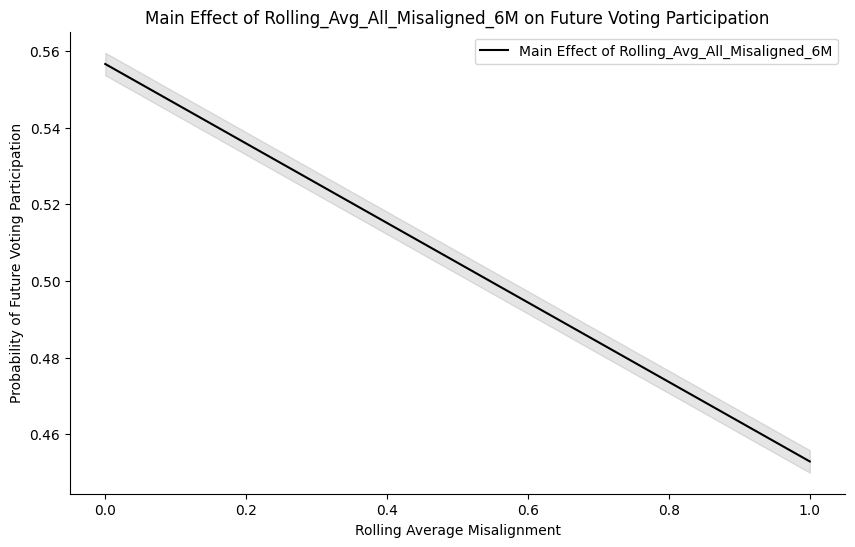

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Define the coefficients and standard errors
intercept = 0.5566
coeff_misalignment = -0.1037
std_err_misalignment = 0.0015

# Critical value for 95% CI
z = norm.ppf(0.975)

# Generate a range of values for Rolling_Avg_All_Misaligned
misalignment_values = np.linspace(0, 1, 100)

# Calculate the predicted probabilities for Future_Voting_Participation_Proposal
prob_main_effect = intercept + coeff_misalignment * misalignment_values
lower_main = prob_main_effect - z * std_err_misalignment
upper_main = prob_main_effect + z * std_err_misalignment

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the line for the main effect
plt.plot(misalignment_values, prob_main_effect, 'k-', label='Main Effect of Rolling_Avg_All_Misaligned_6M')

# Plot the confidence intervals for the main effect
plt.fill_between(misalignment_values, lower_main, upper_main, color='k', alpha=0.1)

# Adding titles and labels
plt.xlabel('Rolling Average Misalignment')
plt.ylabel('Probability of Future Voting Participation')
plt.title('Main Effect of Rolling_Avg_All_Misaligned_6M on Future Voting Participation')
plt.legend()

# Remove the top and right spines to improve aesthetics
sns.despine()

# Show the plot
plt.show()


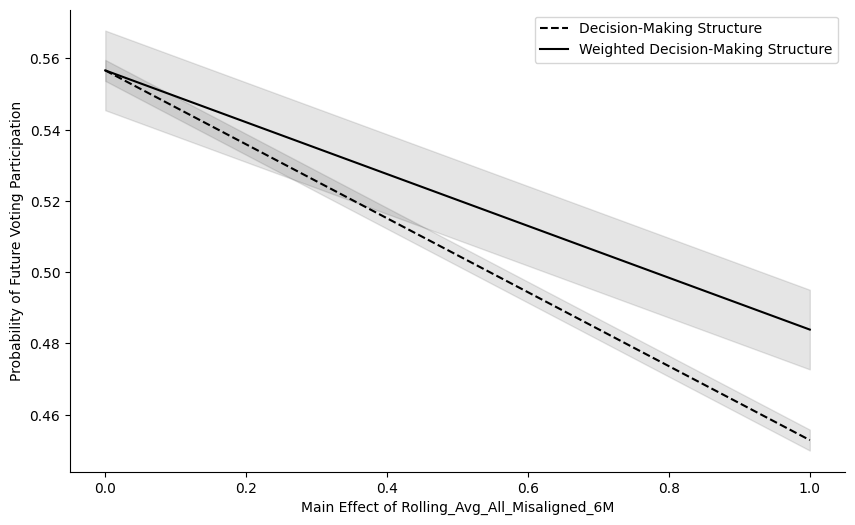

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Define the coefficients and standard errors
intercept = 0.5566
coeff_misalignment = -0.1037
coeff_interaction = 0.0310
std_err_misalignment = 0.0015
std_err_interaction = 0.0042

# Critical value for 95% CI
z = norm.ppf(0.975)

# Generate a range of values for Rolling_Avg_All_Misaligned
misalignment_values = np.linspace(0, 1, 100)

# Calculate the predicted probabilities for both scenarios
# Without voting rule delegation
prob_without_delegation = intercept + coeff_misalignment * misalignment_values
lower_without = prob_without_delegation - z * std_err_misalignment
upper_without = prob_without_delegation + z * std_err_misalignment

# With voting rule delegation
prob_with_delegation = intercept + (coeff_misalignment + coeff_interaction) * misalignment_values
lower_with = prob_with_delegation - z * (std_err_misalignment + std_err_interaction)
upper_with = prob_with_delegation + z * (std_err_misalignment + std_err_interaction)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the lines for with and without voting rule delegation
plt.plot(misalignment_values, prob_without_delegation, 'k--', label='Decision-Making Structure')
plt.plot(misalignment_values, prob_with_delegation, 'k-', label='Weighted Decision-Making Structure')

# Plot the confidence intervals
plt.fill_between(misalignment_values, lower_without, upper_without, color='k', alpha=0.1)
plt.fill_between(misalignment_values, lower_with, upper_with, color='k', alpha=0.1)

# Adding titles and labels
plt.xlabel('Main Effect of Rolling_Avg_All_Misaligned_6M')
plt.ylabel('Probability of Future Voting Participation')
plt.legend()

# Remove the top and right spines to improve aesthetics
sns.despine()

# Show the plot
plt.show()


/var/folders/f4/sh07l6153kdf65d301tvvp8h0000gn/T/ipykernel_72813/4186514795.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = data_clean_drop.groupby('bin')['Future_Voting_Participation_Proposal'].mean()
/var/folders/f4/sh07l6153kdf65d301tvvp8h0000gn/T/ipykernel_72813/4186514795.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_midpoints = data_clean_drop.groupby('bin')['Rolling_Avg_Misaligned_6M'].apply(lambda x: x.mean())


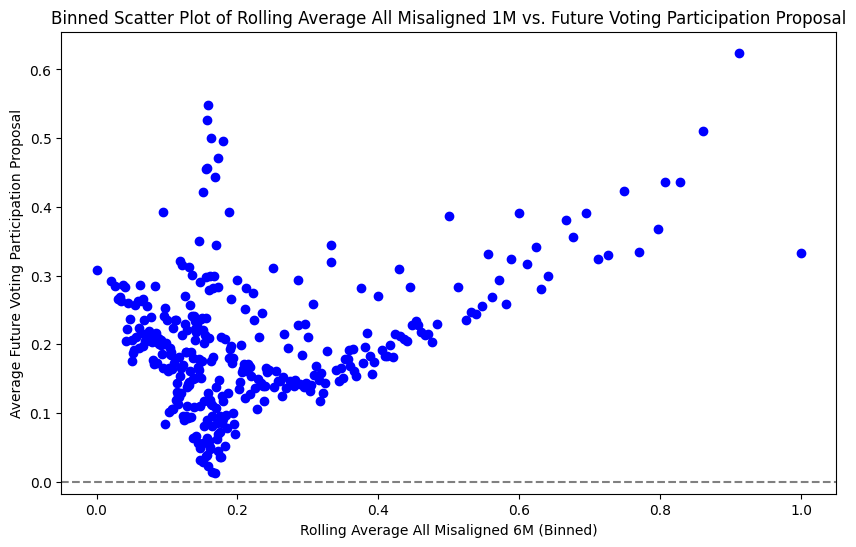

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure your DataFrame is named data_clean_drop
# data_clean_drop = pd.read_csv('your_data_file.csv')  # Uncomment and modify if reading from a file

# Number of bins - you can adjust this as needed
n_bins = 1000

# Create bins for the independent variable
data_clean_drop['bin'] = pd.qcut(data_clean_drop['Rolling_Avg_Misaligned_6M'], q=n_bins, duplicates='drop')

# Calculate the average of the dependent variable for each bin
binned_data = data_clean_drop.groupby('bin')['Future_Voting_Participation_Proposal'].mean()

# Calculate bin midpoints for plotting
bin_midpoints = data_clean_drop.groupby('bin')['Rolling_Avg_Misaligned_6M'].apply(lambda x: x.mean())

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(bin_midpoints, binned_data, color='blue')
plt.axhline(y=0, color='gray', linestyle='--')

# Adding labels and title
plt.xlabel('Rolling Average All Misaligned 6M (Binned)')
plt.ylabel('Average Future Voting Participation Proposal')
plt.title('Binned Scatter Plot of Rolling Average All Misaligned 1M vs. Future Voting Participation Proposal')

# Show the plot
plt.show()


## Topic Modelling: LDA

In [67]:
# Intentionally break the code
result = 1 / 0

ZeroDivisionError: division by zero

In [68]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Assuming data_clean['title'] contains the titles
titles = data_clean['title']

# Tokenization, removing stop words, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing to each title
preprocessed_titles = titles.apply(preprocess_text)

# Now, let's vectorize the preprocessed text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(preprocessed_titles)


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 5

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
lda.fit(dtm)

# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
aave arfc ethereum add parameter risk update arc polygon optimism
Topic 1:
proposal security curve rate election council arbitrum budget protocol whitelist
Topic 2:
check aave temp arfc gauge deployment upgrade deploy plan vote
Topic 3:
season cycle request community committee group mai bal wallet contract
Topic 4:
proposal governance dao grant voting fund phase special cycle election


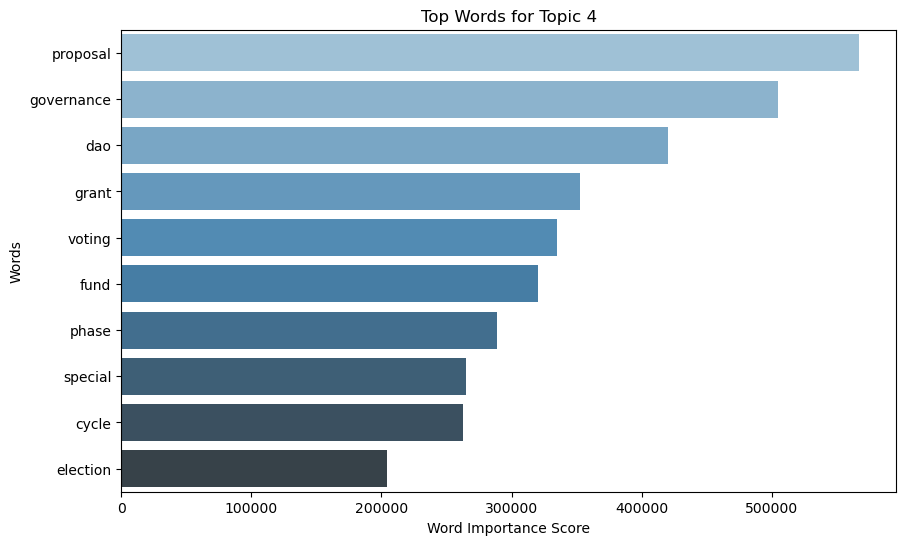

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose the topic number you want to visualize, for example, topic 0-4
topic_number = 4

# Extract the word scores for the chosen topic
word_scores = lda.components_[topic_number]

# Get feature names (words) and their scores
words = vectorizer.get_feature_names_out()
scores = word_scores

# Create a DataFrame with words and their scores
df_topic_words = pd.DataFrame({'Word': words, 'Score': scores})

# Sort the DataFrame by score to get top words
df_top_words = df_topic_words.sort_values(by='Score', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Word', data=df_top_words, palette='Blues_d')
plt.title(f'Top Words for Topic {topic_number}')
plt.xlabel('Word Importance Score')
plt.ylabel('Words')
plt.show()


### GPT4 — Aided Interpretations

Topic 0: DeFi (Blockchain Technology)

Keywords: aave, arfc, ethereum, add, parameter, risk, update, arc, polygon, optimism
Interpretation: This topic seems to be centered around DeFi (Decentralized Finance) protocols, with a strong focus on the Aave platform and Ethereum blockchain. It suggests discussions or proposals related to risk parameters, updates, and perhaps governance (ARC could imply Aave Request for Comment) on various blockchain networks, including Polygon and Optimism.

Topic 1: Governance (Proposals and Security)

Keywords: proposal, security, curve, rate, election, council, arbitrum, budget, protocol, whitelist
Interpretation: This topic appears to relate to governance proposals that deal with security measures, economic parameters (like rates and budgets), and organizational structures (elections and councils). It may also involve protocol-level discussions on platforms like Curve and Arbitrum, and actions such as whitelisting for security or access control.

Topic 2: Deployment (Protocol and Updates)

Keywords: check, aave, temp, arfc, gauge, deployment, upgrade, deploy, plan, vote
Interpretation: This topic likely deals with the operational aspects of DeFi platforms, such as checking and deploying smart contracts, upgrading systems, and planning. It points to the technical side of protocol management within these platforms, including voting on deployment plans.

Topic 3: Community (Engagement and Requests)

Keywords: season, cycle, request, community, committee, group, mai, bal, wallet, contract
Interpretation: Here, the focus is on community engagement and organizational activities within DAOs or DeFi ecosystems. This could include seasonal or cyclical funding requests, committee formations, group activities, and issues relating to wallets and smart contracts.

Topic 4: Funding (Cycles)

Keywords: proposal, governance, dao, grant, voting, fund, phase, special, cycle, election
Interpretation: This topic is indicative of governance-related activities within DAOs, such as voting on proposals, managing grants and funding, and the different phases of election cycles. It reflects the democratic and financial processes that are fundamental to DAO operations.

Trained LDA model with 1 topics
Trained LDA model with 2 topics
Trained LDA model with 3 topics
Trained LDA model with 4 topics
Trained LDA model with 5 topics
Trained LDA model with 6 topics
Trained LDA model with 7 topics
Trained LDA model with 8 topics
Trained LDA model with 9 topics
Trained LDA model with 10 topics


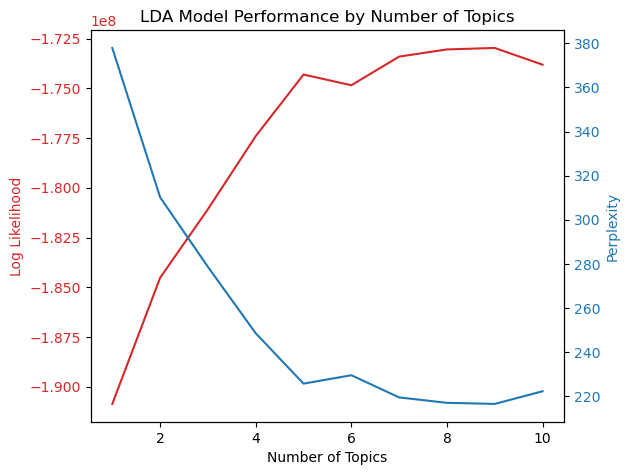

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Range of possible topic numbers to explore
topic_numbers = range(1, 11)

log_likelihoods = []
perplexities = []

for n in topic_numbers:
    lda_model = LatentDirichletAllocation(n_components=n, max_iter=10, learning_method='online', random_state=42)
    lda_model.fit(dtm)
    
    # Store the model's log-likelihood and perplexity for evaluation
    log_likelihoods.append(lda_model.score(dtm))
    perplexities.append(lda_model.perplexity(dtm))
    
    print(f"Trained LDA model with {n} topics")

# Plotting the evaluation metrics
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Log Likelihood', color=color)
ax1.plot(topic_numbers, log_likelihoods, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(topic_numbers, perplexities, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('LDA Model Performance by Number of Topics')
plt.show()


Coherence Score for 1 topics: 0.45166184305865364
Coherence Score for 2 topics: 0.4206853014832913
Coherence Score for 3 topics: 0.4114177615764641
Coherence Score for 4 topics: 0.40227060260585157
Coherence Score for 5 topics: 0.3731899723882005
Coherence Score for 6 topics: 0.34232237667889415
Coherence Score for 7 topics: 0.3593991953605333
Coherence Score for 8 topics: 0.36505335940859485
Coherence Score for 9 topics: 0.36399557637110974
Coherence Score for 10 topics: 0.3596132764007455


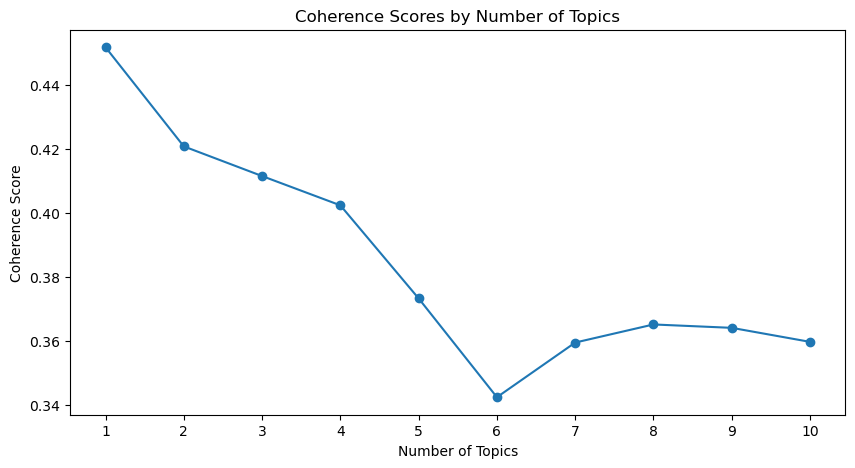

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import matutils
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import numpy as np

# Ensure the preprocessed titles are split into lists of words
tokenized_titles = [doc.split() for doc in preprocessed_titles]

# Create a Gensim dictionary and corpus from the tokenized titles
dictionary = Dictionary(tokenized_titles)
corpus = [dictionary.doc2bow(text) for text in tokenized_titles]

# Initialize lists to store coherence scores and models
coherence_scores = []

# Explore LDA models with 1 to 10 topics
for n_topics in range(1, 11):
    # Train LDA model using sklearn
    lda_sklearn = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
    lda_sklearn.fit(dtm)
    
    # Convert the sklearn LDA model's components_ array to Gensim's format
    term_topic_matrix = lda_sklearn.components_.T
    gensim_corpus = matutils.Dense2Corpus(term_topic_matrix, documents_columns=False)
    
    # Manually create a Gensim LdaModel (for coherence score calculation purposes only)
    gensim_lda = LdaModel(corpus=gensim_corpus, id2word=dictionary, num_topics=n_topics, passes=10)
    
    # Calculate Coherence Score using Gensim's CoherenceModel
    coherence_model = CoherenceModel(model=gensim_lda, texts=tokenized_titles, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    print(f"Coherence Score for {n_topics} topics: {coherence_score}")

# Plotting the coherence scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), coherence_scores, marker='o')
plt.title("Coherence Scores by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(range(1, 11))
plt.show()


In [ ]:
# Generate topic distributions
topic_distributions = lda.transform(dtm)

# Convert topic distributions to a DataFrame
topic_df = pd.DataFrame(topic_distributions, columns=['DeFi', 'Governance', 'Deployment', 'Community', 'Funding'])

# Merge the topic distributions with your original DataFrame
data_clean = pd.concat([data_clean.reset_index(drop=True), topic_df.reset_index(drop=True)], axis=1)

In [ ]:
# Check if the merge was successful by printing the new columns
print("Columns after merge:", data_clean.columns)

Columns after merge: Index(['space_vote', 'created_vote', 'DAO_Creation_Date', 'Blockchain_Network',
       'title', 'Proposal_ID', 'Participated_Before',
       'Participated_in_previous_proposal', 'Total_Proposals_Participated',
       'Misaligned', 'Aligned', 'NotDetermined', 'voting_power',
       'log_voting_power', 'duration_of_voting_period_days',
       'time_since_last_vote_days', 'size_of_dao', 'total_votes_on_proposal',
       'past_votes_within_dao_proposal', 'presence_in_other_daos',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'proposal_start_date', 'proposal_end_date', 'Tenure_Upto_Proposal',
       'type', 'choice', 'winning_choice', 'scores', 'Voting_rule_delegation',
       'Voting_rule_mixed', 'Cumulative_Misaligned', 'Vote_Count',
       'Rolling_Avg_All_Misaligned', 'days_since_earliest',
       'Rolling_Avg_Misaligned_7D', 'Rolling_Avg_Misaligned_1M',
       'Rolling_Avg_Misaligned_1Q

In [ ]:
# Check if the merge was successful by printing the new columns
print("Columns after merge:", data_clean.columns)

Columns after merge: Index(['space_vote', 'created_vote', 'DAO_Creation_Date', 'Blockchain_Network',
       'title', 'Proposal_ID', 'Participated_Before',
       'Participated_in_previous_proposal', 'Total_Proposals_Participated',
       'Misaligned', 'Aligned', 'NotDetermined', 'voting_power',
       'log_voting_power', 'duration_of_voting_period_days',
       'time_since_last_vote_days', 'size_of_dao', 'total_votes_on_proposal',
       'past_votes_within_dao_proposal', 'presence_in_other_daos',
       'Future_Voting_Participation_Proposal',
       'Future_Voting_Participation_DAO', 'Future_Participation_Count',
       'proposal_start_date', 'proposal_end_date', 'Tenure_Upto_Proposal',
       'type', 'choice', 'winning_choice', 'scores', 'Voting_rule_delegation',
       'Voting_rule_mixed', 'Cumulative_Misaligned', 'Vote_Count',
       'Rolling_Avg_All_Misaligned', 'days_since_earliest',
       'Rolling_Avg_Misaligned_7D', 'Rolling_Avg_Misaligned_1M',
       'Rolling_Avg_Misaligned_1Q

In [ ]:
# Assuming data_clean includes the topic distribution columns
topic_columns = ['DeFi', 'Governance', 'Deployment', 'Community', 'Funding']
correlation_matrix = data_clean_drop[topic_columns].corr()

print(correlation_matrix)


                DeFi  Governance  Deployment  Community   Funding
DeFi        1.000000   -0.217948   -0.295516  -0.296658 -0.347203
Governance -0.217948    1.000000   -0.152271  -0.142899 -0.231316
Deployment -0.295516   -0.152271    1.000000  -0.250174 -0.286177
Community  -0.296658   -0.142899   -0.250174   1.000000 -0.236439
Funding    -0.347203   -0.231316   -0.286177  -0.236439  1.000000


In [ ]:
# Check the correlation matrix for the explanatory variables, including the topic distributions
corr_matrix = data_for_regression.corr()
print(corr_matrix)

                                      Blockchain_Network  Participated_Before  \
Blockchain_Network                              1.000000            -0.144390   
Participated_Before                            -0.144390             1.000000   
Participated_in_previous_proposal              -0.000146            -0.000038   
Total_Proposals_Participated                   -0.223288             0.231129   
Misaligned                                      0.045191            -0.018175   
Aligned                                        -0.043839             0.022239   
NotDetermined                                  -0.011792            -0.039935   
voting_power                                   -0.002916             0.001896   
log_voting_power                                0.065375            -0.076630   
duration_of_voting_period_days                  0.040120            -0.012601   
time_since_last_vote_days                       0.063782             0.107704   
size_of_dao                 